In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor

plt.style.use('seaborn-darkgrid')

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [3]:
LitDF = pd.read_csv('COVID_Education_Merged.csv', index_col = 0)
LitDF.head()

State    cases  deaths  4th 2015 Math  4th 2015 Science  \
0     Alabama   387786   14345            231               145   
1      Alaska    18316     367            236               154   
2     Arizona   426614   18857            238               149   
3    Arkansas   161569    3301            235               150   
4  California  2664110  102387            232               140   

   8th 2015 Math  8th 2015 Science  Labor Force w/ Bachelor 2018  \
0            267               141                        624760   
1            280               154                        108145   
2            283               148                       1014830   
3            275               148                        347335   
4            275               143                       7115070   

   Labor Force Participants 2018  Percent of Labor Force w/ Bachelor 2018  \
0                        2219105                                28.153693   
1                         371180                                29.135460   
2                        3396895                                29.875224   
3                        1379145                                25.184807   
4                       20038675                                35.506689   

   Doctorate From Doc Inst 2018  Doctorate From Bach Inst 2018  \
0                        493174                         248175   
1                           506                            293   
2                        560204                         321105   
3                         20363                          15171   
4                      49711105                        2676741   

   Total Doctorate Degrees 2018  Less Than HS Diploma 14-18  HS Diploma 14-18  \
0                        741349                    470043.0         1020172.0   
1                           799                     34760.0          133851.0   
2                        881309                    613002.0         1112551.0   
3                         35534                    276029.0          681223.0   
4                      52387846                   4475565.0         5391120.0   

   Some College or Associate Degree 14-18  Bachelor Degree or Higher 14-18  \
0                                987148.0                         822595.0   
1                                169471.0                         139645.0   
2                               1570308.0                        1338071.0   
3                                590434.0                         451621.0   
4                               7633463.0                        8718737.0   

   ELL Students Enrolled 2017  
0                       25212  
1                       15623  
2                       88629  
3                       39836  
4                     1197296

In [4]:
LitDF = LitDF.drop(columns = ['cases', 'deaths'])
LitDF.head()

State  4th 2015 Math  4th 2015 Science  8th 2015 Math  \
0     Alabama            231               145            267   
1      Alaska            236               154            280   
2     Arizona            238               149            283   
3    Arkansas            235               150            275   
4  California            232               140            275   

   8th 2015 Science  Labor Force w/ Bachelor 2018  \
0               141                        624760   
1               154                        108145   
2               148                       1014830   
3               148                        347335   
4               143                       7115070   

   Labor Force Participants 2018  Percent of Labor Force w/ Bachelor 2018  \
0                        2219105                                28.153693   
1                         371180                                29.135460   
2                        3396895                                29.875224   
3                        1379145                                25.184807   
4                       20038675                                35.506689   

   Doctorate From Doc Inst 2018  Doctorate From Bach Inst 2018  \
0                        493174                         248175   
1                           506                            293   
2                        560204                         321105   
3                         20363                          15171   
4                      49711105                        2676741   

   Total Doctorate Degrees 2018  Less Than HS Diploma 14-18  HS Diploma 14-18  \
0                        741349                    470043.0         1020172.0   
1                           799                     34760.0          133851.0   
2                        881309                    613002.0         1112551.0   
3                         35534                    276029.0          681223.0   
4                      52387846                   4475565.0         5391120.0   

   Some College or Associate Degree 14-18  Bachelor Degree or Higher 14-18  \
0                                987148.0                         822595.0   
1                                169471.0                         139645.0   
2                               1570308.0                        1338071.0   
3                                590434.0                         451621.0   
4                               7633463.0                        8718737.0   

   ELL Students Enrolled 2017  
0                       25212  
1                       15623  
2                       88629  
3                       39836  
4                     1197296

In [5]:
COVID = pd.read_csv('COVID.csv', index_col = 0)
COVID.head()

State   cases  deaths
0     Alabama   26912     785
1      Alaska     751      10
2     Arizona   39298    1228
3    Arkansas   13191     188
4  California  159098    5202

In [6]:
LitDF = pd.merge(LitDF, COVID, how = 'left', on = 'State')
LitDF.head()

State  4th 2015 Math  4th 2015 Science  8th 2015 Math  \
0     Alabama            231               145            267   
1      Alaska            236               154            280   
2     Arizona            238               149            283   
3    Arkansas            235               150            275   
4  California            232               140            275   

   8th 2015 Science  Labor Force w/ Bachelor 2018  \
0               141                        624760   
1               154                        108145   
2               148                       1014830   
3               148                        347335   
4               143                       7115070   

   Labor Force Participants 2018  Percent of Labor Force w/ Bachelor 2018  \
0                        2219105                                28.153693   
1                         371180                                29.135460   
2                        3396895                                29.875224   
3                        1379145                                25.184807   
4                       20038675                                35.506689   

   Doctorate From Doc Inst 2018  Doctorate From Bach Inst 2018  \
0                        493174                         248175   
1                           506                            293   
2                        560204                         321105   
3                         20363                          15171   
4                      49711105                        2676741   

   Total Doctorate Degrees 2018  Less Than HS Diploma 14-18  HS Diploma 14-18  \
0                        741349                    470043.0         1020172.0   
1                           799                     34760.0          133851.0   
2                        881309                    613002.0         1112551.0   
3                         35534                    276029.0          681223.0   
4                      52387846                   4475565.0         5391120.0   

   Some College or Associate Degree 14-18  Bachelor Degree or Higher 14-18  \
0                                987148.0                         822595.0   
1                                169471.0                         139645.0   
2                               1570308.0                        1338071.0   
3                                590434.0                         451621.0   
4                               7633463.0                        8718737.0   

   ELL Students Enrolled 2017   cases  deaths  
0                       25212   26912     785  
1                       15623     751      10  
2                       88629   39298    1228  
3                       39836   13191     188  
4                     1197296  159098    5202

In [7]:
test_len = int(0.25 * len(LitDF))
train_len = len(LitDF) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = LitDF[:train_len]
test = LitDF[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 18)
Test Set Shape: (12, 18)


## 4th Math (2015)

In [8]:
features_list = ['4th 2015 Math']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 22613.46928836138
Train MSE Value: 1440051121.1180708
Train RMS Value: 37948.005495916
Train R2 Score: 0.7024577565801405


Test MAE Value: 51771.93135579427
Test MSE Value: 6353501181.845558
Test RMS Value: 79708.85259395947
Test R2 Score: -8.26395559302688


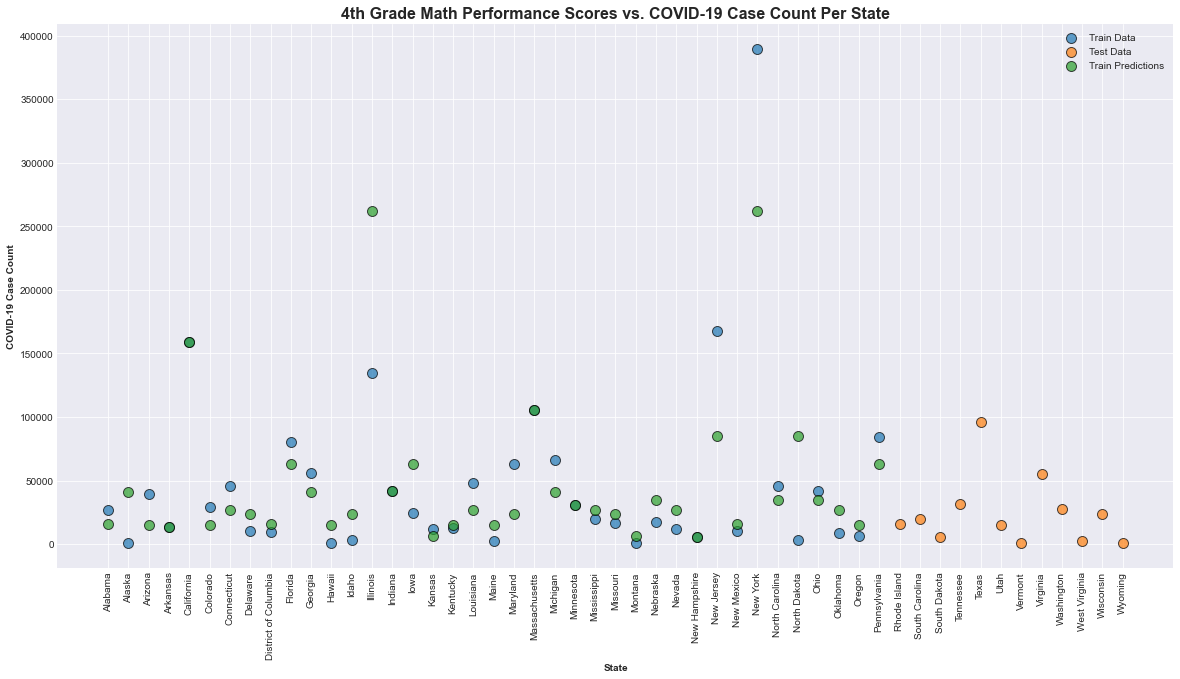

In [9]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('4th Grade Math Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


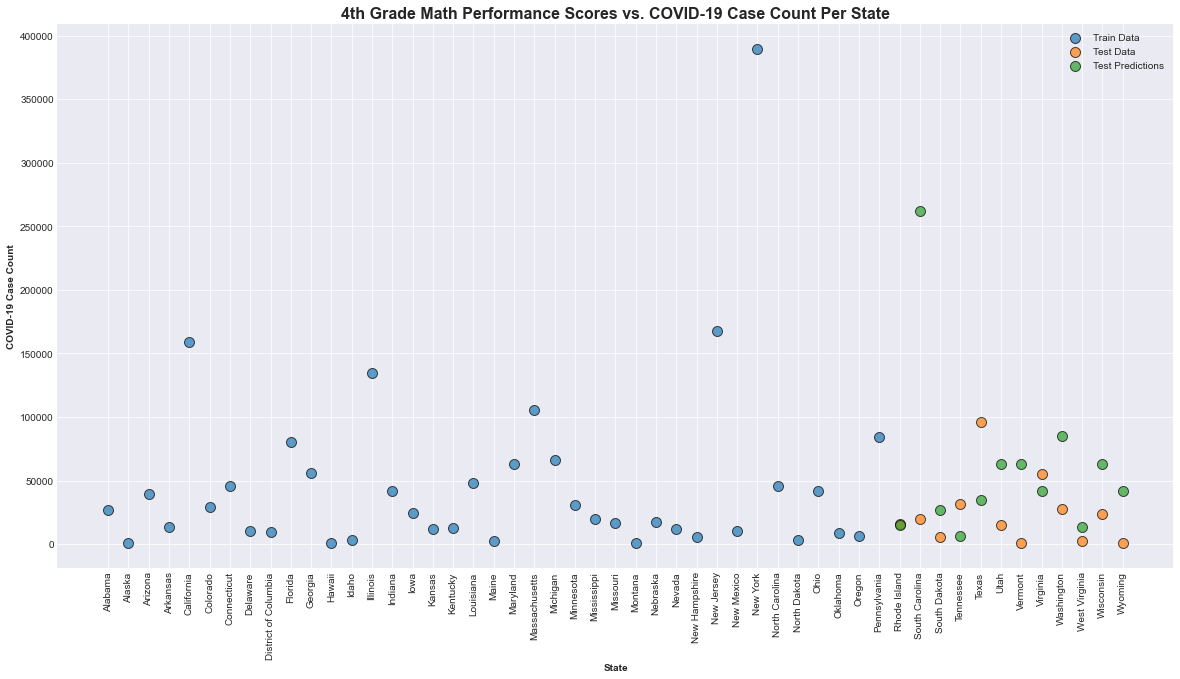

In [10]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('4th Grade Math Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [11]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7776 degrees.
Accuracy = 88.64%.


88.64178005110416

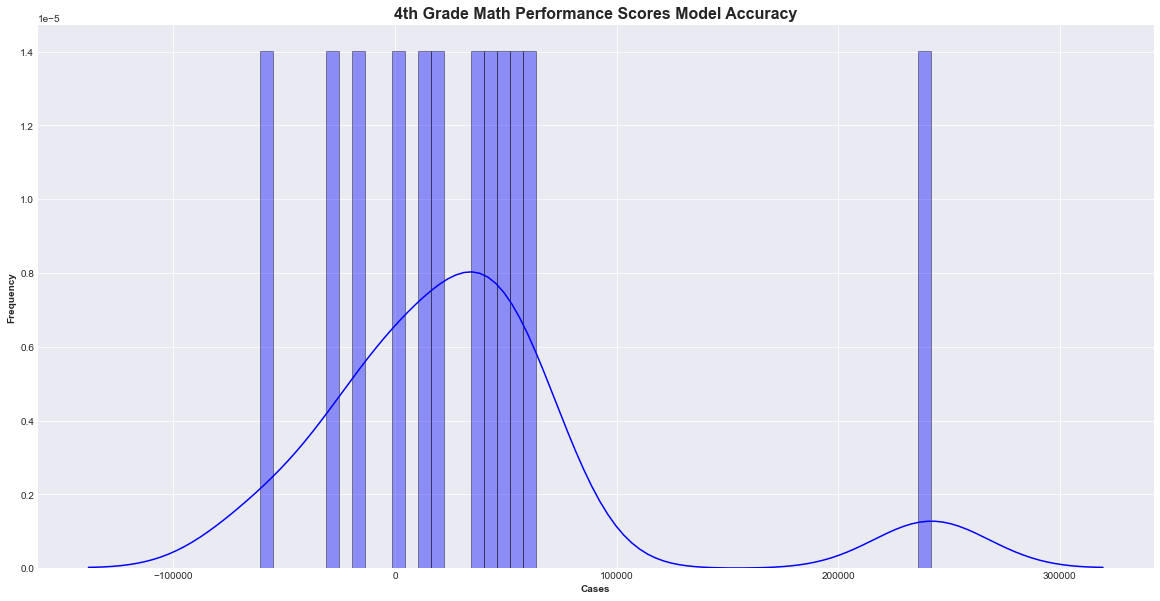

In [12]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('4th Grade Math Performance Scores Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [13]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 3560 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 8088 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 13928 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 21048 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 29480 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 39192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 50171 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.2min finished


In [14]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.06,
 'max_depth': 6,
 'min_child_weight': 1,
 'reg_lambda': 10}

In [15]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 27332.9983974359
Train MSE Value: 1870261421.7607586
Train RMS Value: 43246.5191866439
Train R2 Score: 0.6135680386261192


Test MAE Value: 43950.486653645836
Test MSE Value: 3782550546.566007
Test RMS Value: 61502.443419477306
Test R2 Score: -4.515286656732511


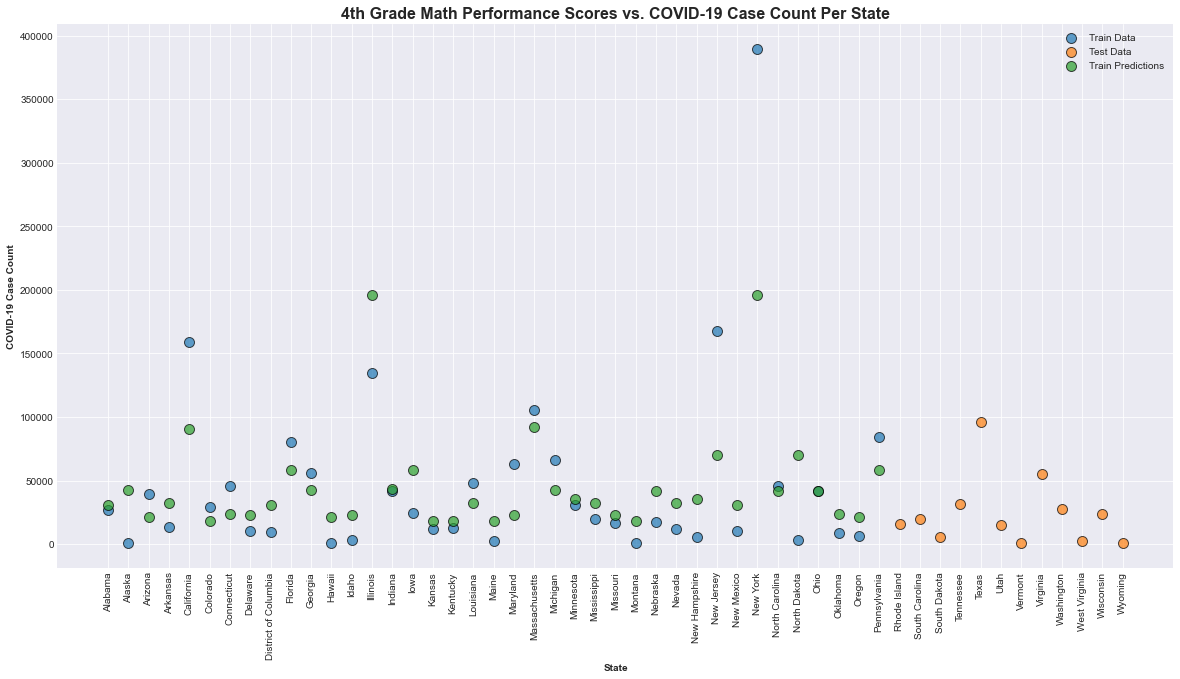

In [16]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('4th Grade Math Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

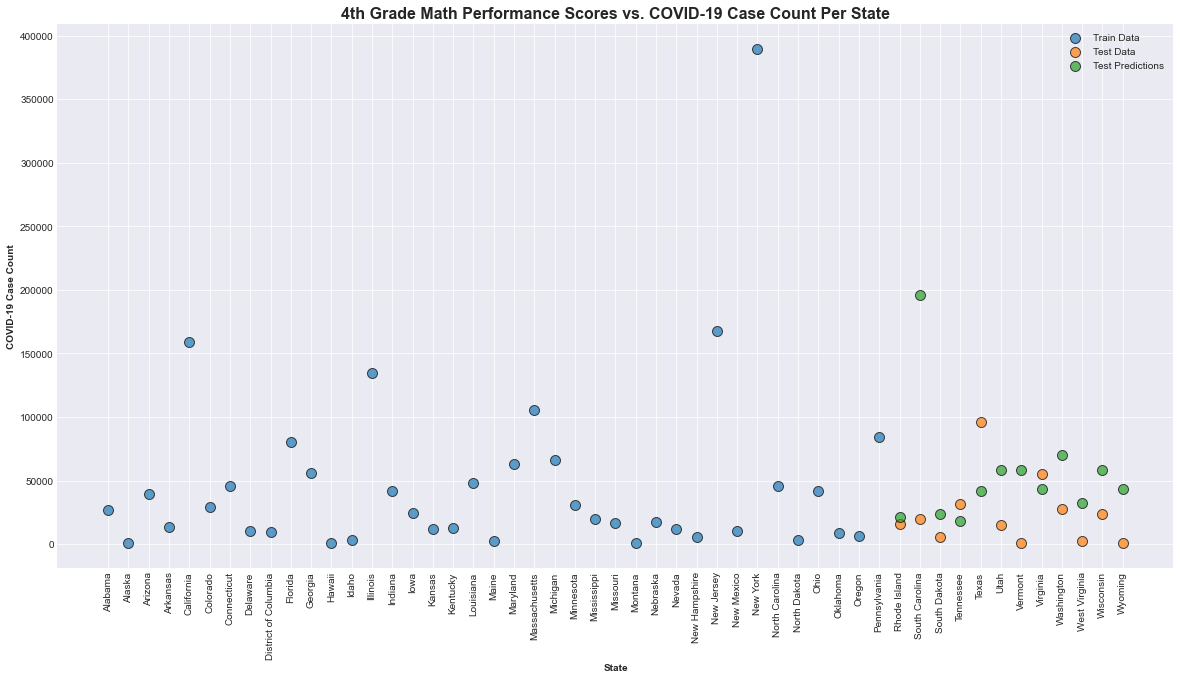

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('4th Grade Math Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [18]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7776 degrees.
Accuracy = 88.64%.


In [19]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6948 degrees.
Accuracy = 95.66%.


In [20]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 7.33%.


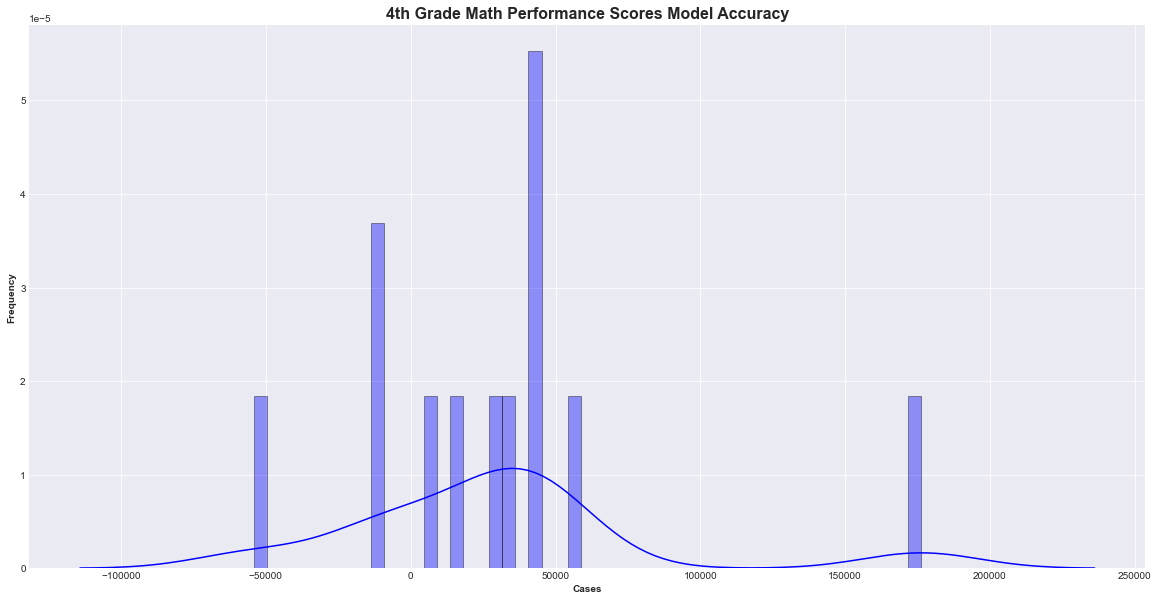

In [21]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('4th Grade Math Performance Scores Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## 4th Science (2015)

In [22]:
features_list = ['4th 2015 Science']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 33402.51770176032
Train MSE Value: 3419551304.1858263
Train RMS Value: 58476.929674751445
Train R2 Score: 0.2934549672467255


Test MAE Value: 36514.35764567057
Test MSE Value: 2624487481.9989934
Test RMS Value: 51229.75192209107
Test R2 Score: -2.826730300635776


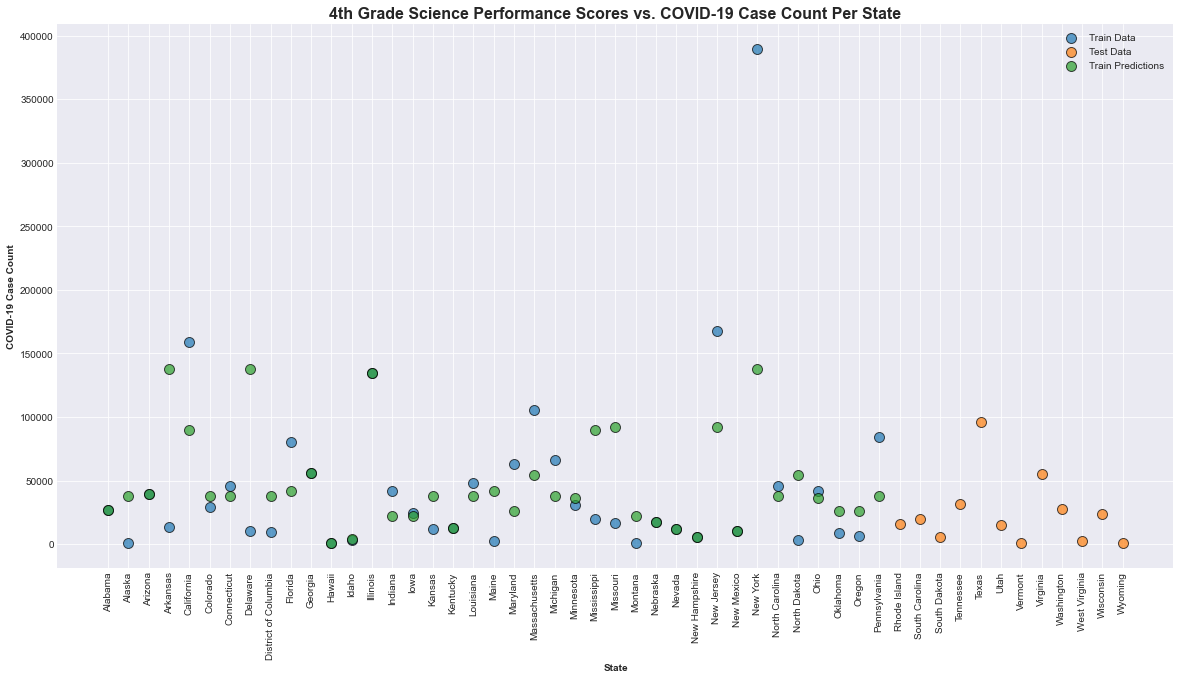

In [23]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('4th Grade Science Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


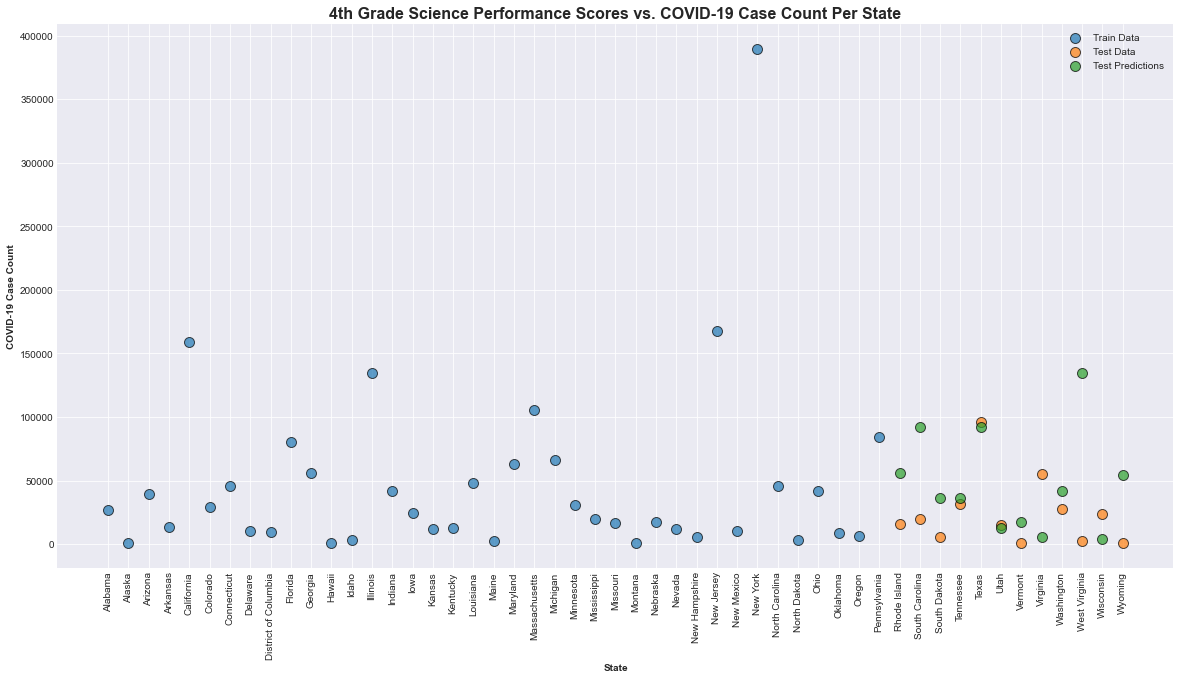

In [24]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('4th Grade Science Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [25]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7214 degrees.
Accuracy = 101.87%.


101.87032929010549

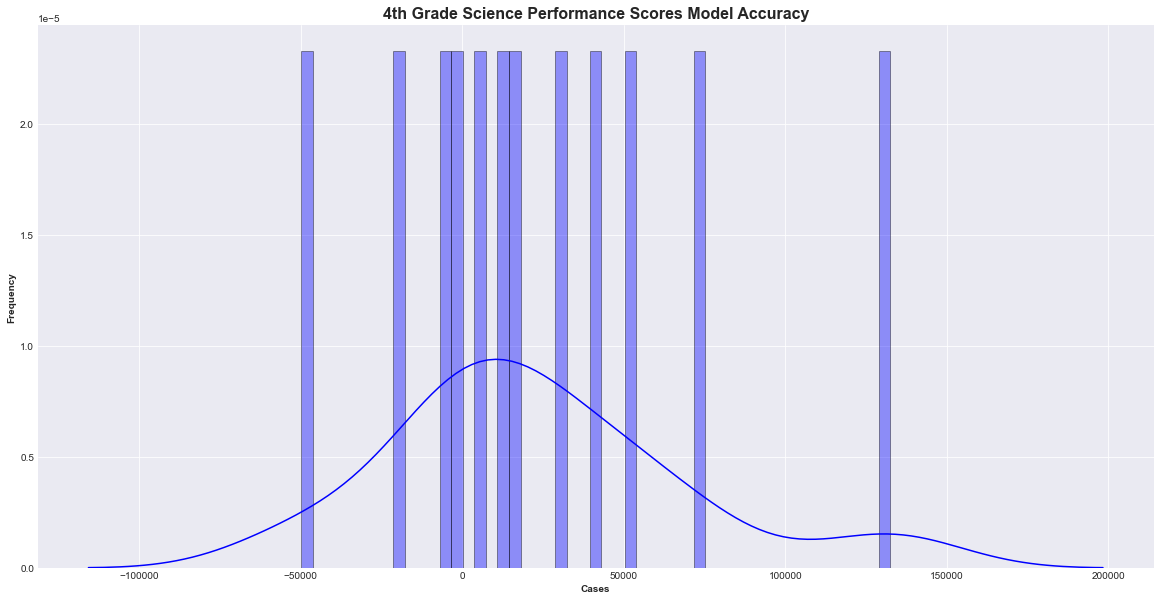

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('4th Grade Science Performance Scores Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [27]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 8808 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 14648 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 21768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 30200 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 39912 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 50261 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.2min finished


In [28]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.08,
 'max_depth': 1,
 'min_child_weight': 3,
 'reg_lambda': 1}

In [29]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 40203.94591346154
Train MSE Value: 4015172223.0833144
Train RMS Value: 63365.38663247715
Train R2 Score: 0.17038823590807728


Test MAE Value: 30775.8134765625
Test MSE Value: 1577325507.0158908
Test RMS Value: 39715.557493454515
Test R2 Score: -1.2998773486494049


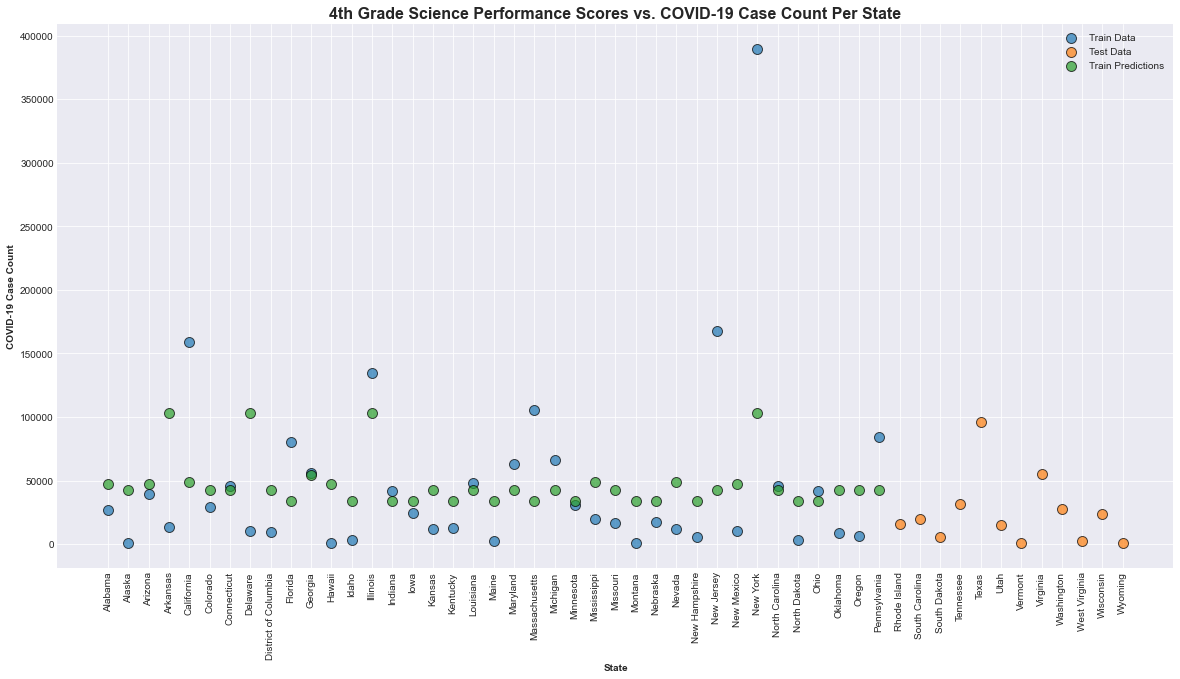

In [30]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('4th Grade Science Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

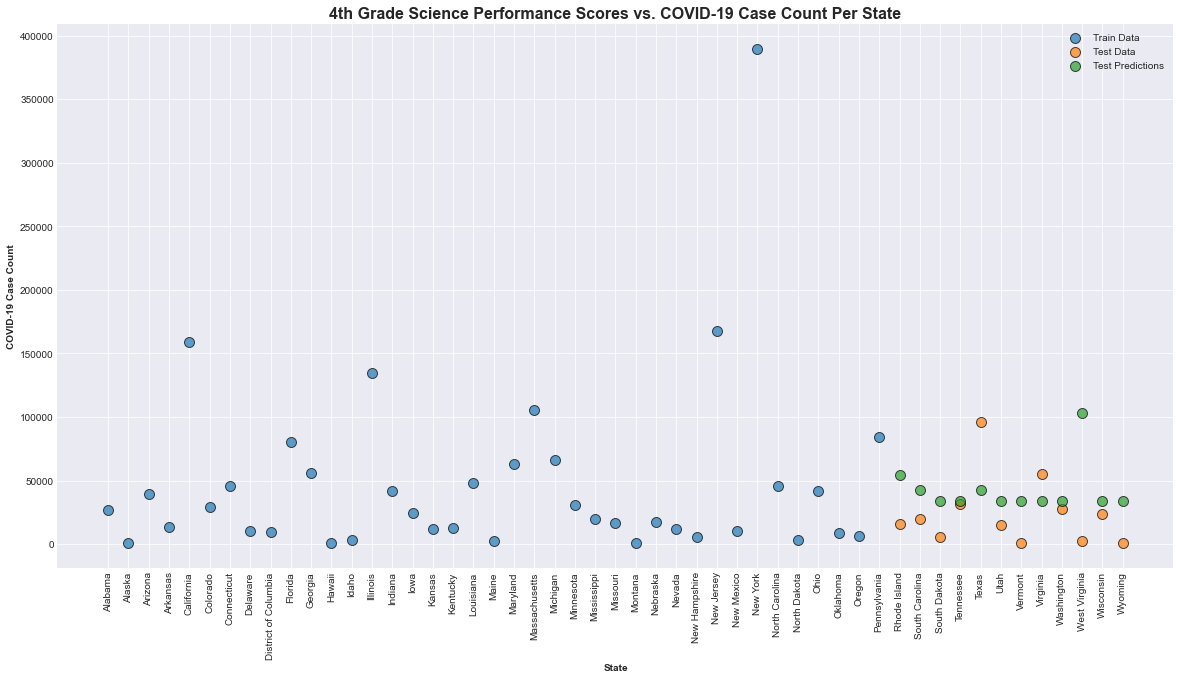

In [31]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('4th Grade Science Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [32]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7214 degrees.
Accuracy = 101.87%.


In [33]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6439 degrees.
Accuracy = 116.13%.


In [34]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 12.28%.


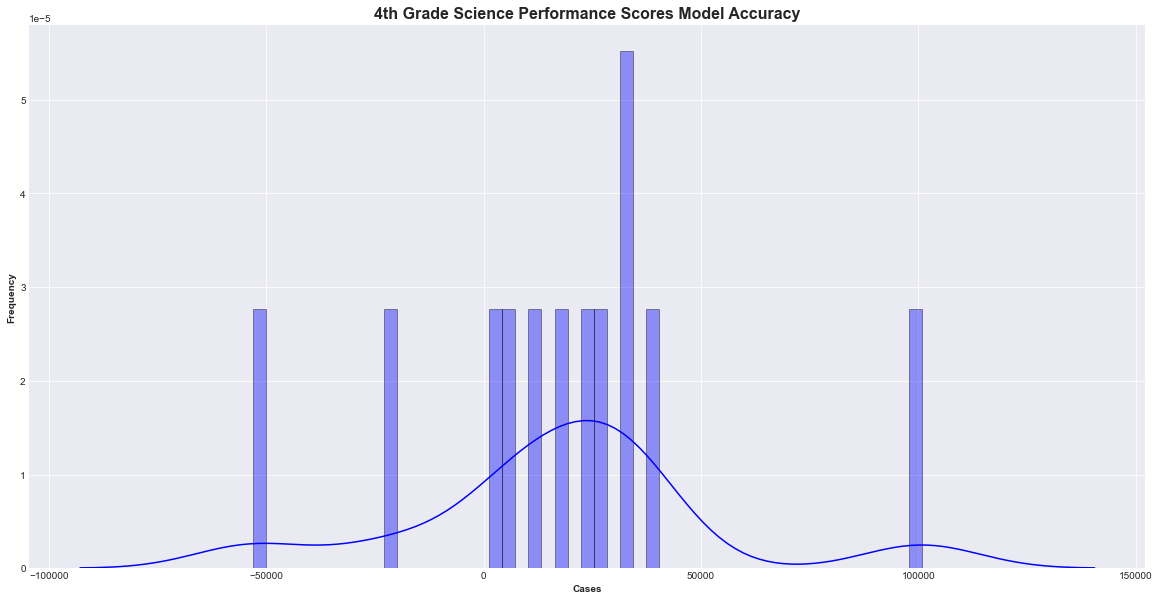

In [35]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('4th Grade Science Performance Scores Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## 8th Math 2015

In [36]:
features_list = [ '8th 2015 Math']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 31143.458377153445
Train MSE Value: 3246980339.313515
Train RMS Value: 56982.280924104074
Train R2 Score: 0.3291114458843525


Test MAE Value: 21397.7651570638
Test MSE Value: 762970613.1487857
Test RMS Value: 27621.922691021813
Test R2 Score: -0.11247730608616968


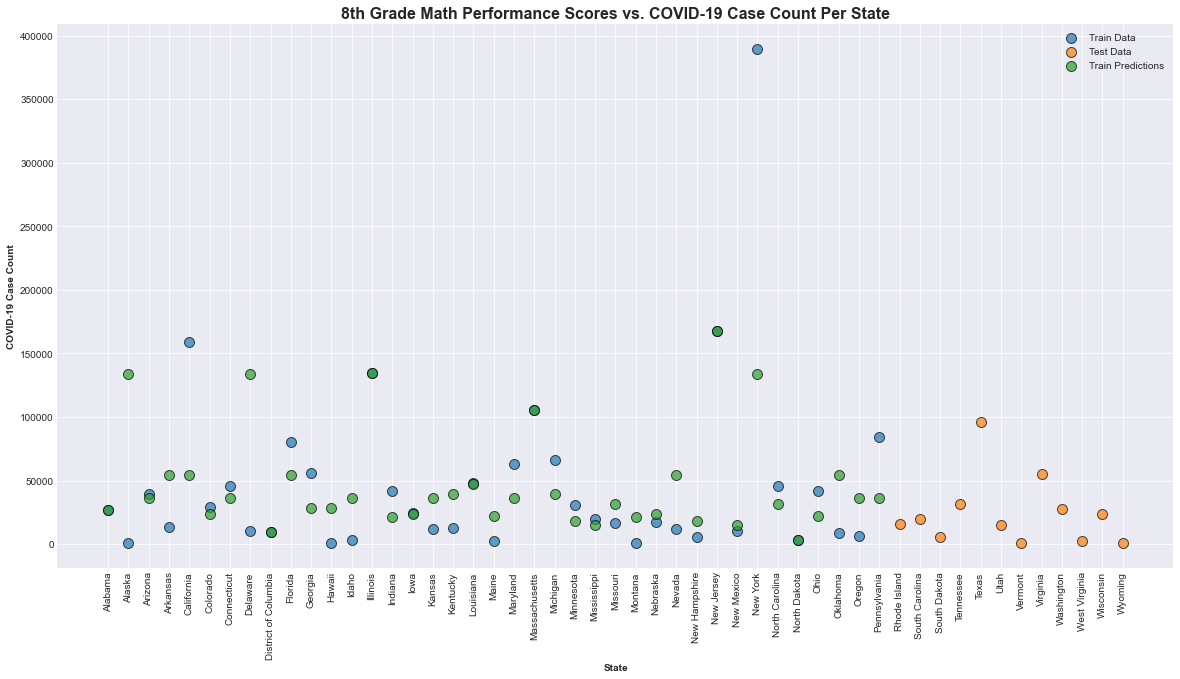

In [37]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('8th Grade Math Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


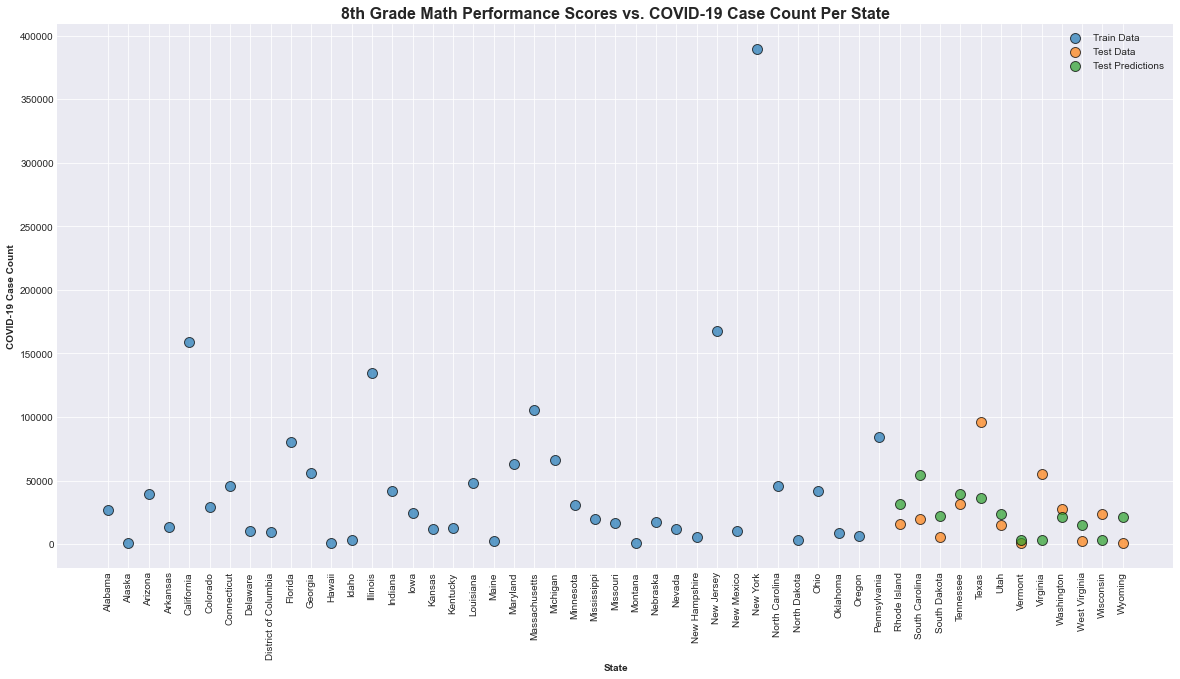

In [38]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('8th Grade Math Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [39]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7204 degrees.
Accuracy = 99.46%.


99.45535692411976

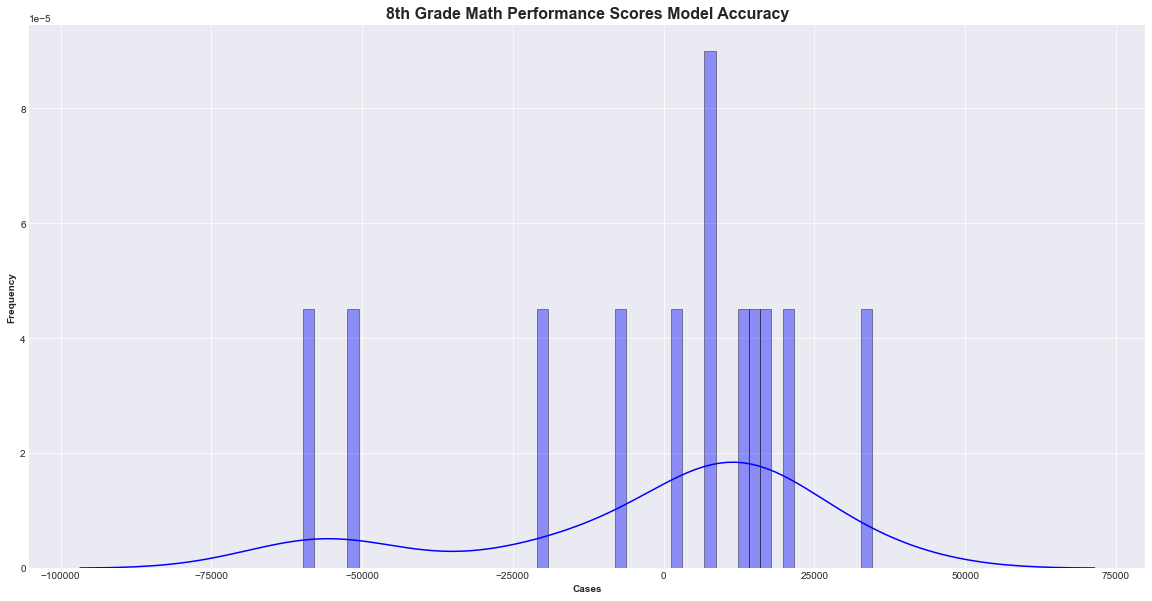

In [40]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('8th Grade Math Performance Scores Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [41]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 8808 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 14648 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 21768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 30200 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 39912 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 50231 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.2min finished


In [42]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 1,
 'min_child_weight': 2,
 'reg_lambda': 1}

In [43]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 41332.83703926282
Train MSE Value: 4375407318.659316
Train RMS Value: 66146.86174460067
Train R2 Score: 0.09595674043933922


Test MAE Value: 30388.506510416668
Test MSE Value: 1109675174.085355
Test RMS Value: 33311.78731448307
Test R2 Score: -0.6180026163818206


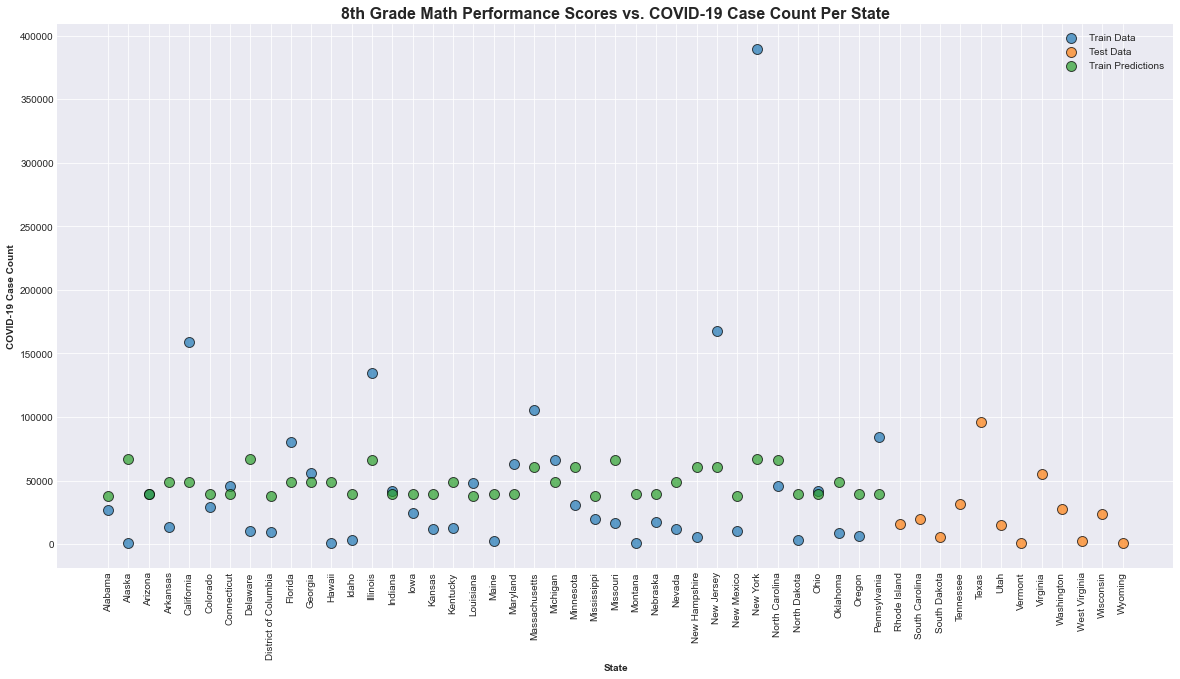

In [44]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('8th Grade Math Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

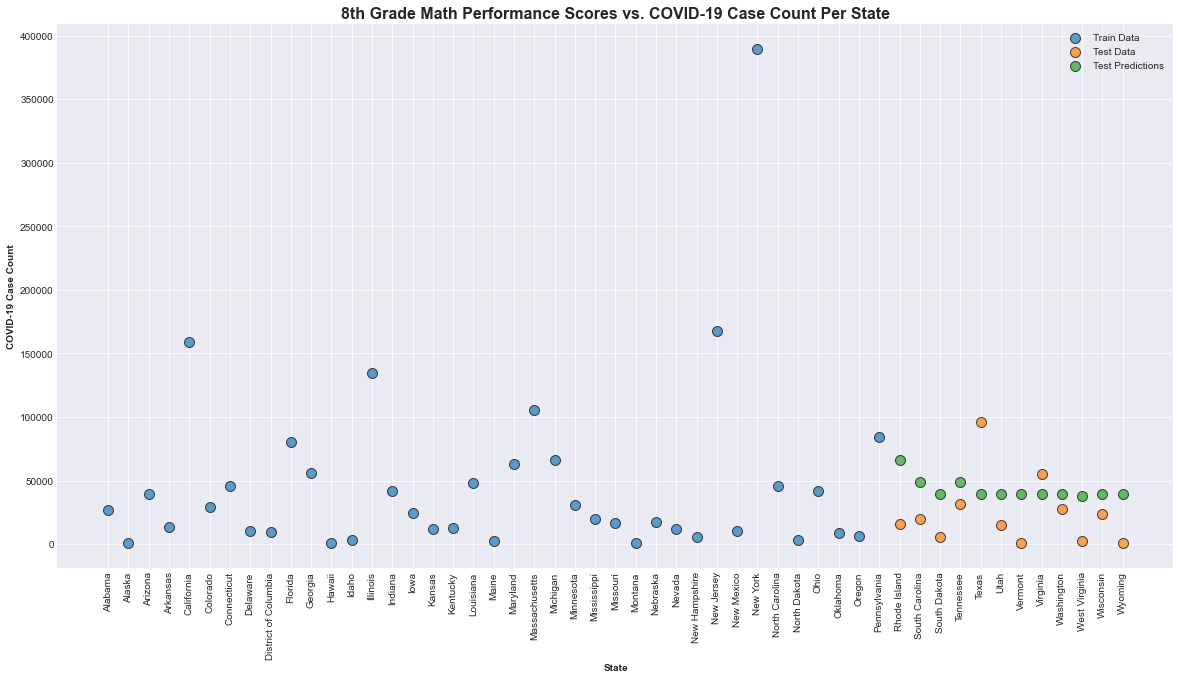

In [45]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('8th Grade Math Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [46]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7204 degrees.
Accuracy = 99.46%.


In [47]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6295 degrees.
Accuracy = 127.24%.


In [48]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 21.83%.


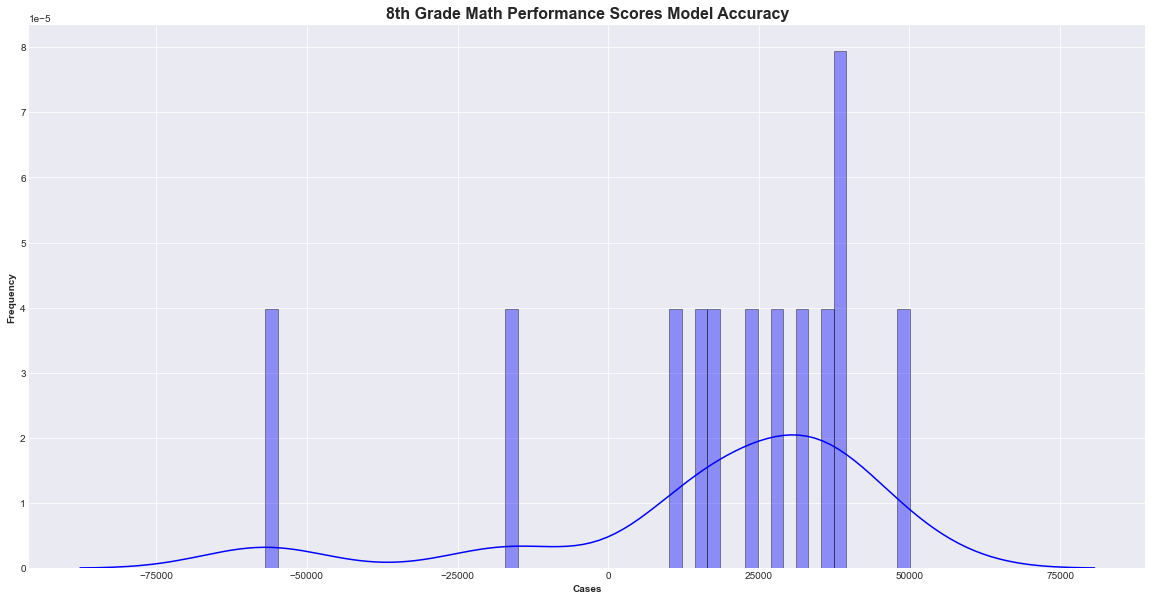

In [49]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('8th Grade Math Performance Scores Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## 8th Science (2015)

In [50]:
features_list = ['8th 2015 Science']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 28156.32769149389
Train MSE Value: 2538656806.171945
Train RMS Value: 50385.08515594615
Train R2 Score: 0.4754647037842461


Test MAE Value: 33902.984537760414
Test MSE Value: 3712254888.38802
Test RMS Value: 60928.27659131694
Test R2 Score: -4.412789492239295


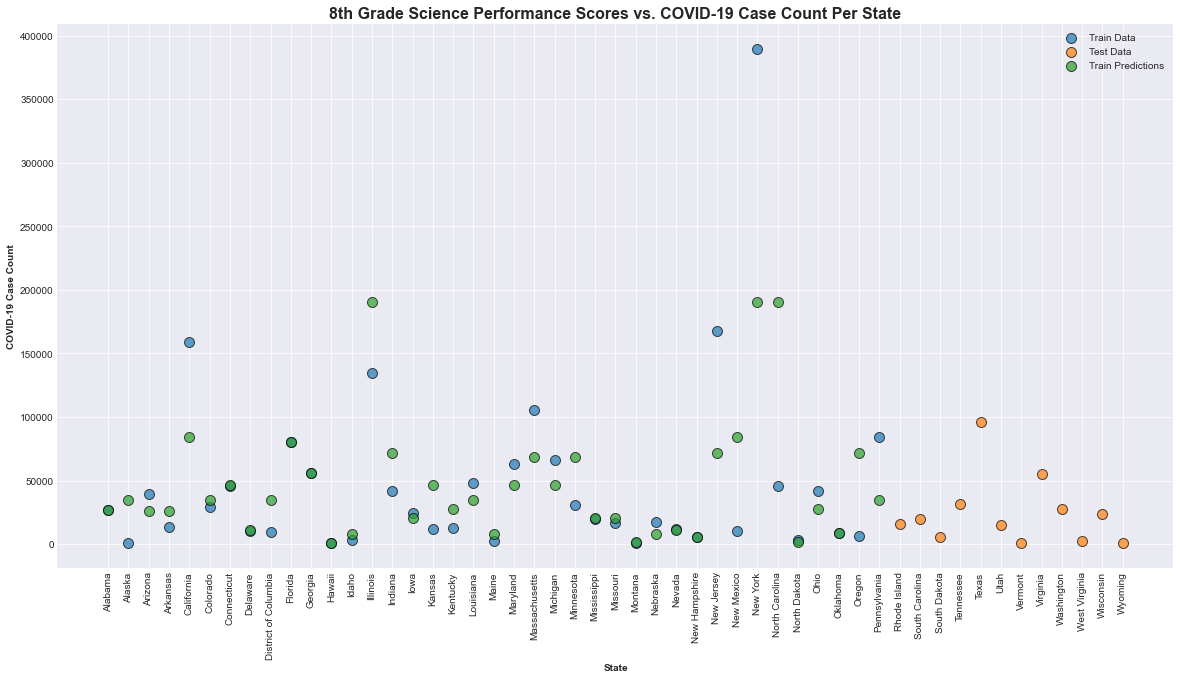

In [51]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('8th Grade Science Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


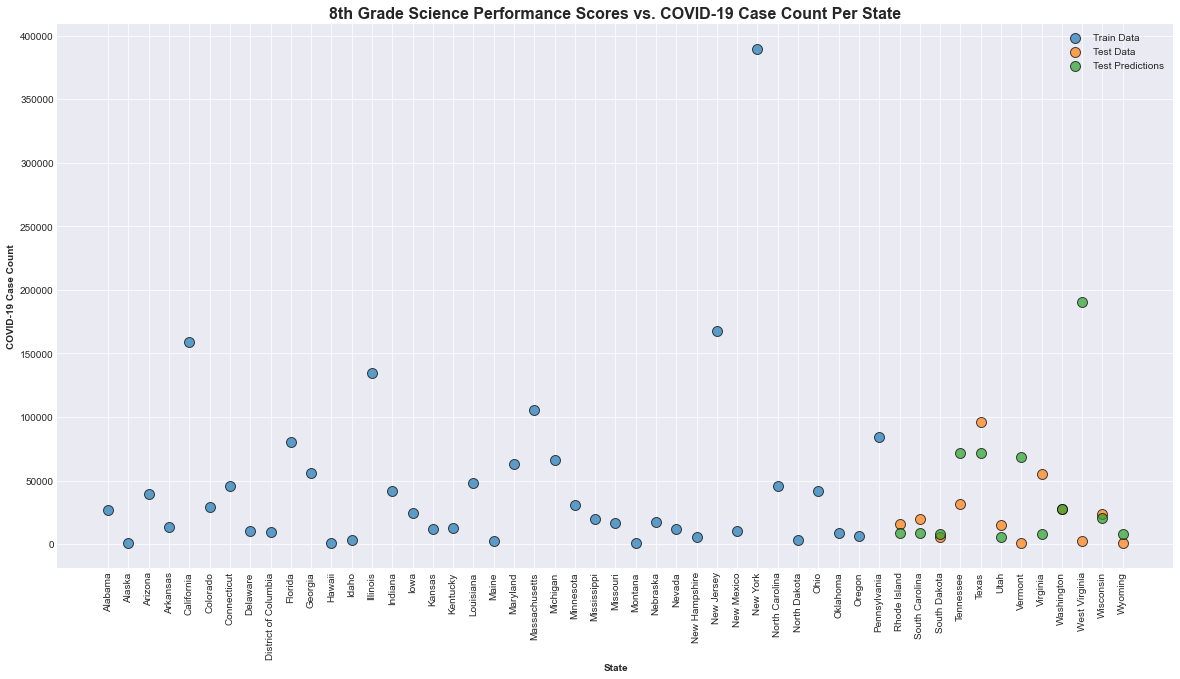

In [52]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('8th Grade Science Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [53]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7635 degrees.
Accuracy = 101.73%.


101.73347728679887

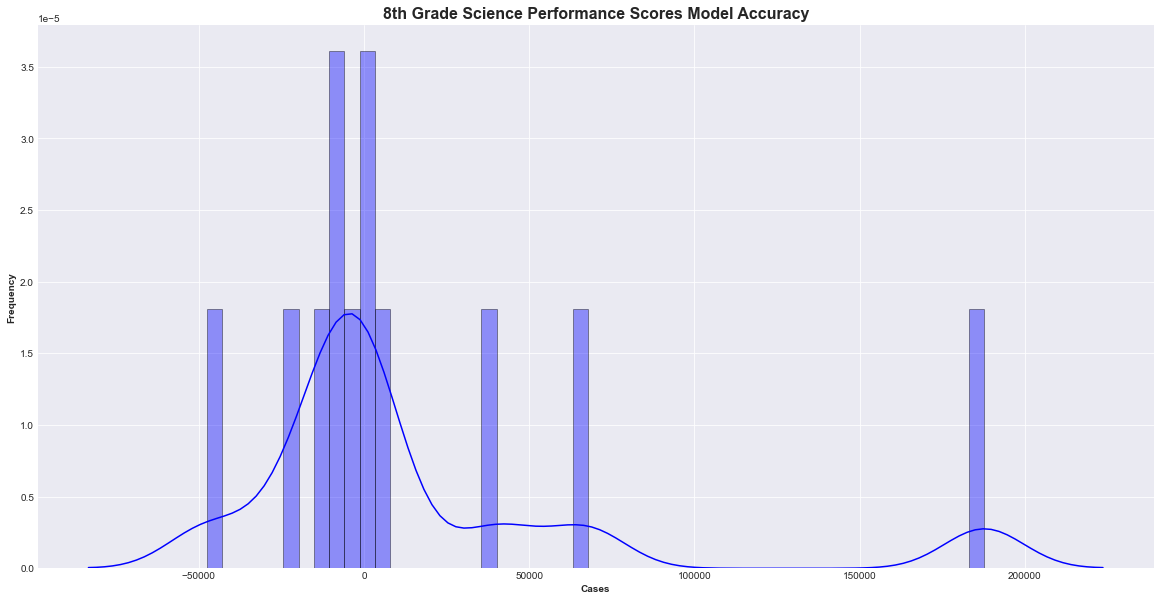

In [54]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('8th Grade Science Performance Scores Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [55]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 8808 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 14228 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 17448 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 21664 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 26520 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 32032 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 38184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 44992 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.5min finished


In [56]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'reg_lambda': 4}

In [57]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 32155.51231971154
Train MSE Value: 2726721334.45623
Train RMS Value: 52218.01733555412
Train R2 Score: 0.4366069571162263


Test MAE Value: 35074.291666666664
Test MSE Value: 3185837803.7938685
Test RMS Value: 56443.22637654468
Test R2 Score: -3.6452277407713716


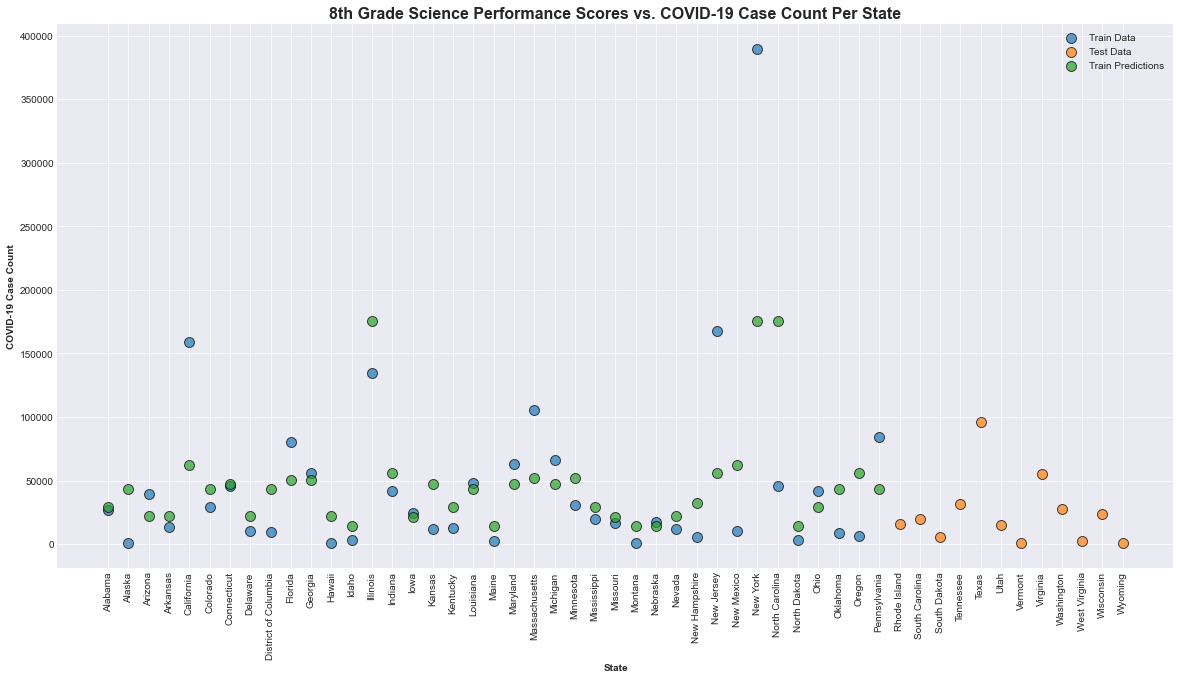

In [58]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('8th Grade Science Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

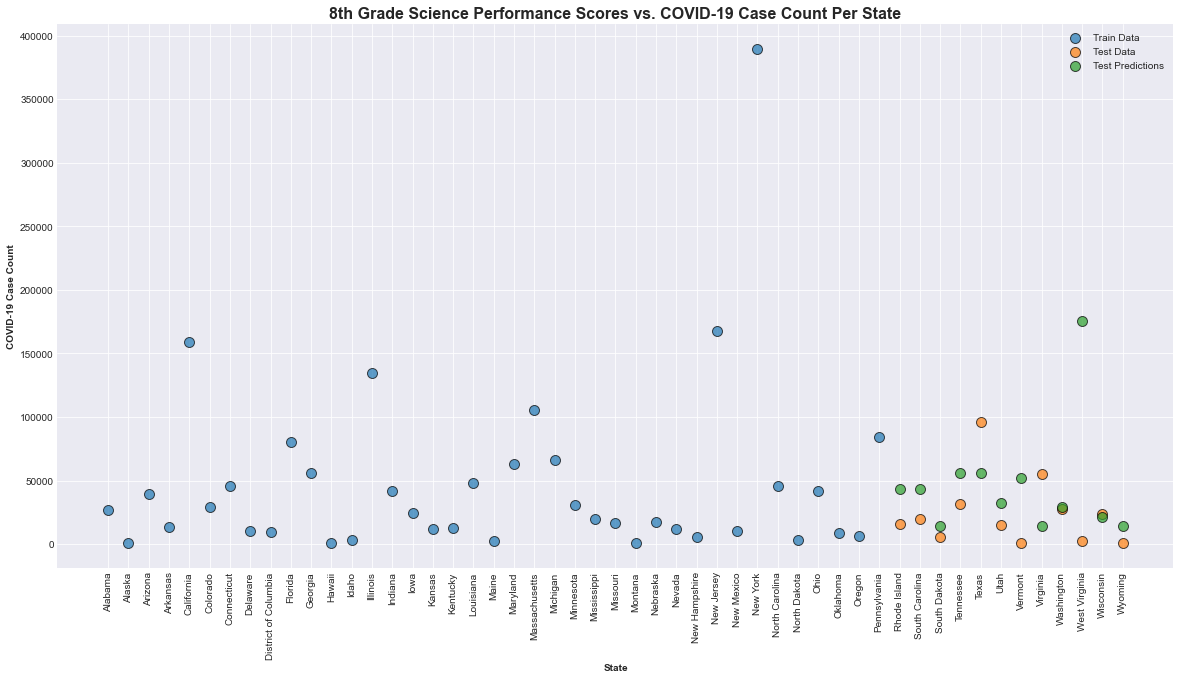

In [59]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('8th Grade Science Performance Scores vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [60]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7635 degrees.
Accuracy = 101.73%.


In [61]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7048 degrees.
Accuracy = 107.60%.


In [62]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 5.45%.


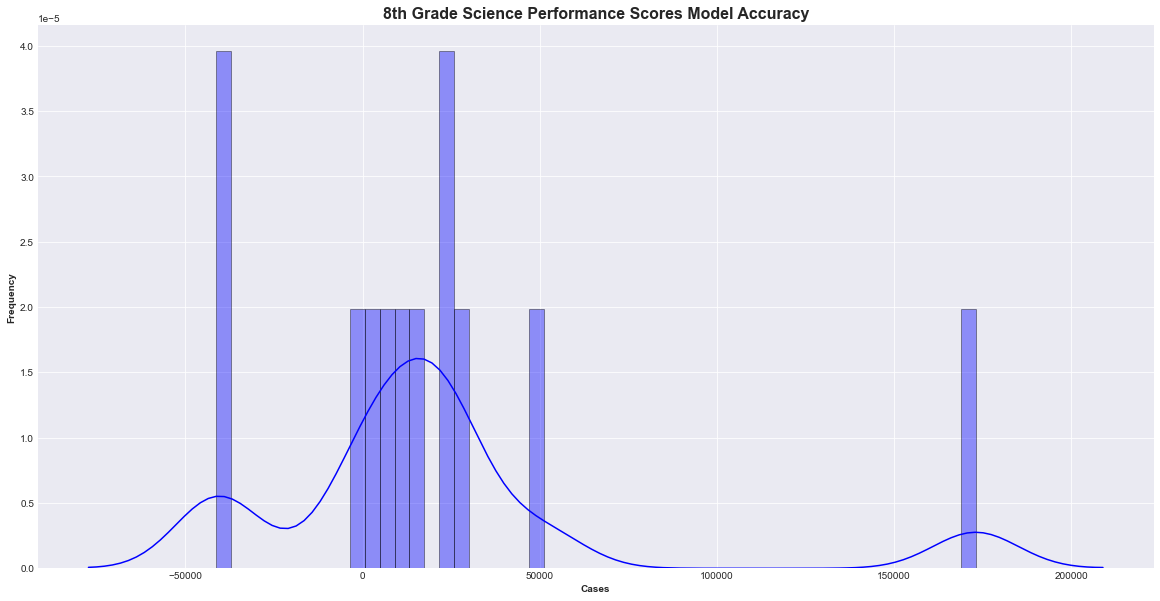

In [63]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('8th Grade Science Performance Scores Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Labor Force Participants (2018)

In [64]:
features_list = ['Labor Force Participants 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 100.86610608223157
Train MSE Value: 14197.368915129453
Train RMS Value: 119.15271257982108
Train R2 Score: 0.9999970665506691


Test MAE Value: 23046.537958780926
Test MSE Value: 1682200043.9272594
Test RMS Value: 41014.63207109457
Test R2 Score: -1.45279351644084


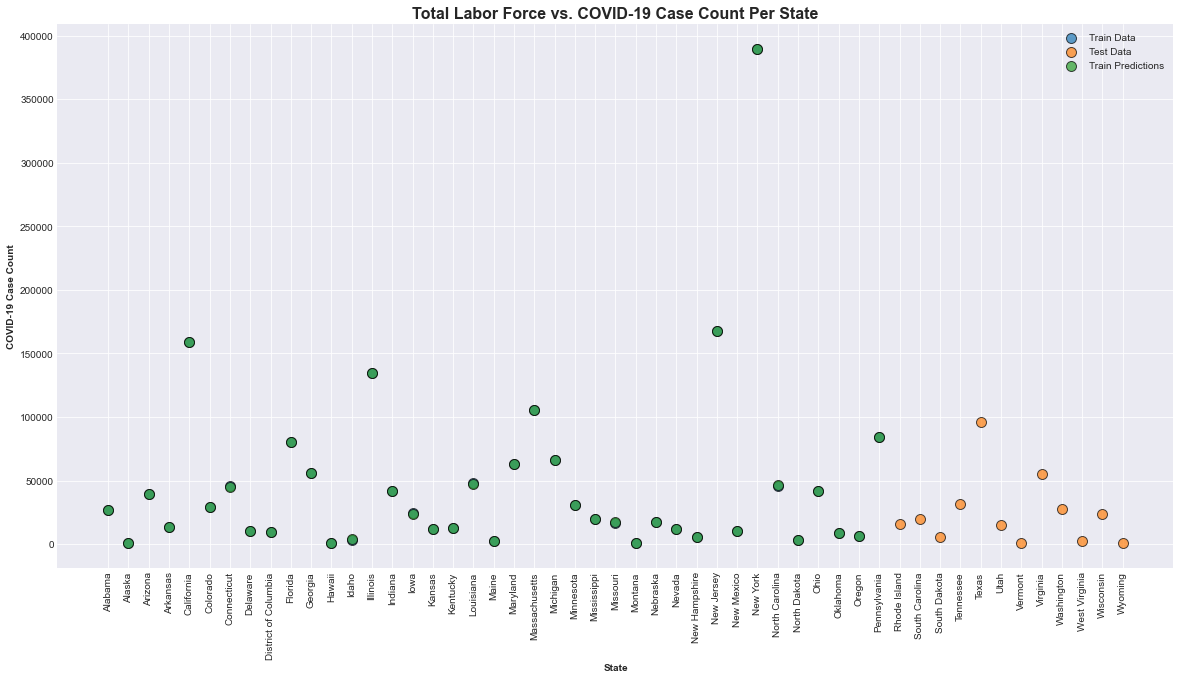

In [65]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Labor Force vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


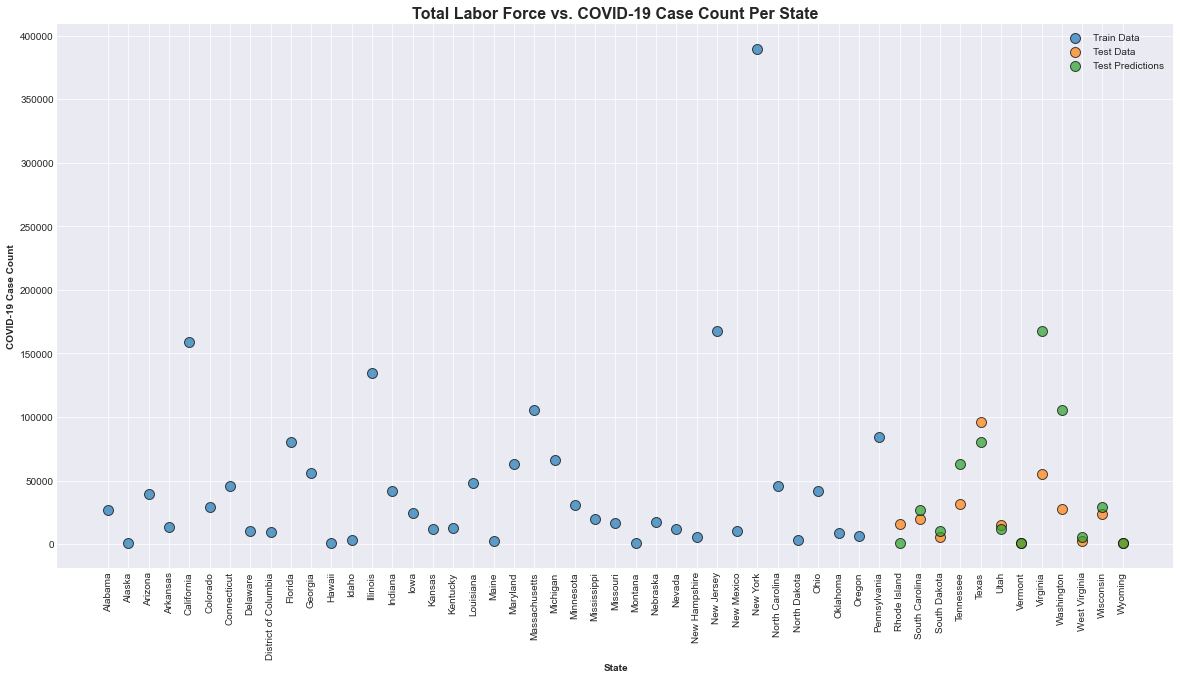

In [66]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Labor Force vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [67]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.22%.


91.22225319642456

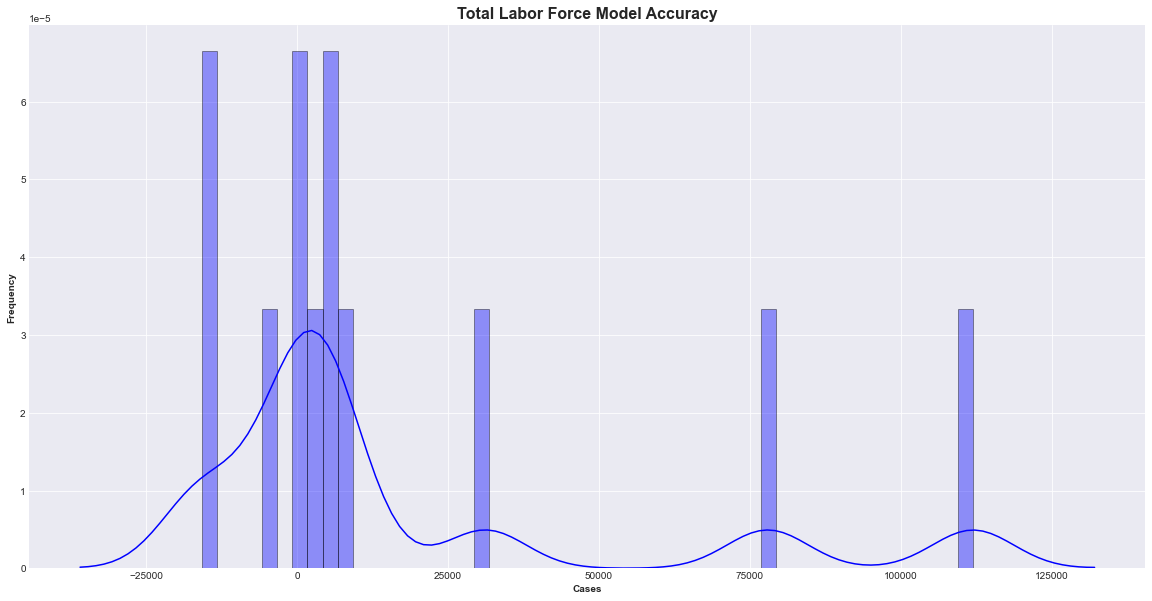

In [68]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Total Labor Force Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [69]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 7800 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 9212 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 10992 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 13100 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 15528 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 18284 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 21360 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 26176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 33624 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 41728 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 50325 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 50400

In [70]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 3,
 'reg_lambda': 10}

In [71]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 16791.42047275641
Train MSE Value: 1639701339.1303737
Train RMS Value: 40493.2258424835
Train R2 Score: 0.6612061837050592


Test MAE Value: 22859.07080078125
Test MSE Value: 1217242089.215722
Test RMS Value: 34888.99667826122
Test R2 Score: -0.7748445050547919


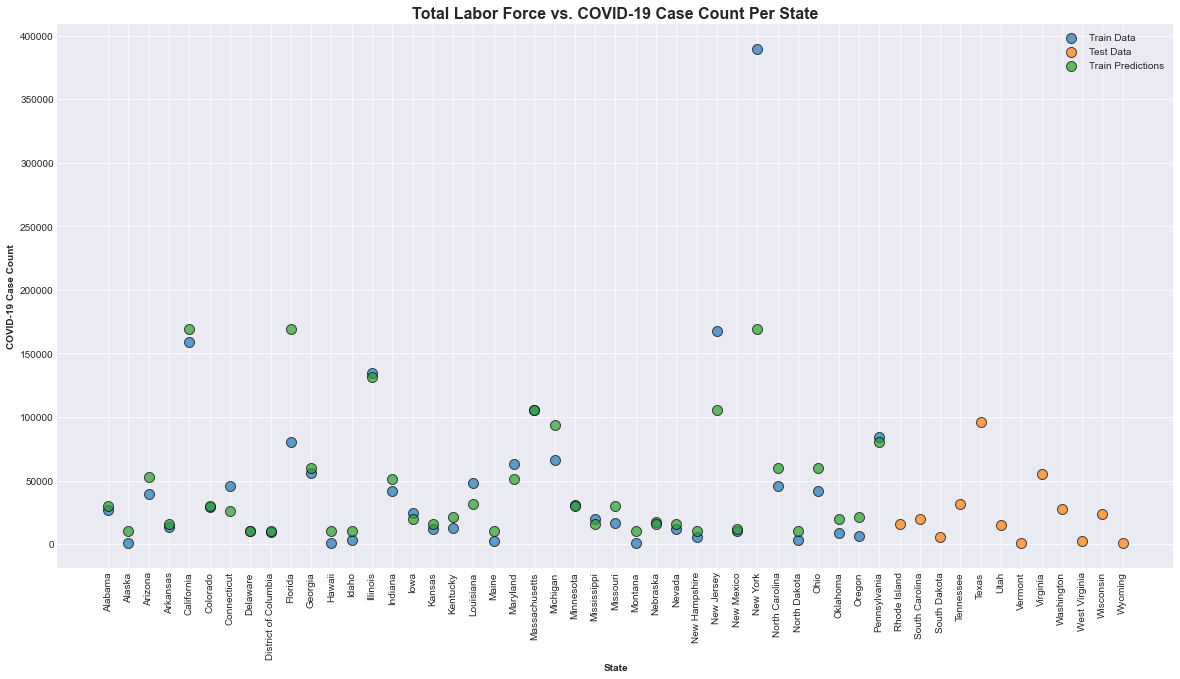

In [72]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Labor Force vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

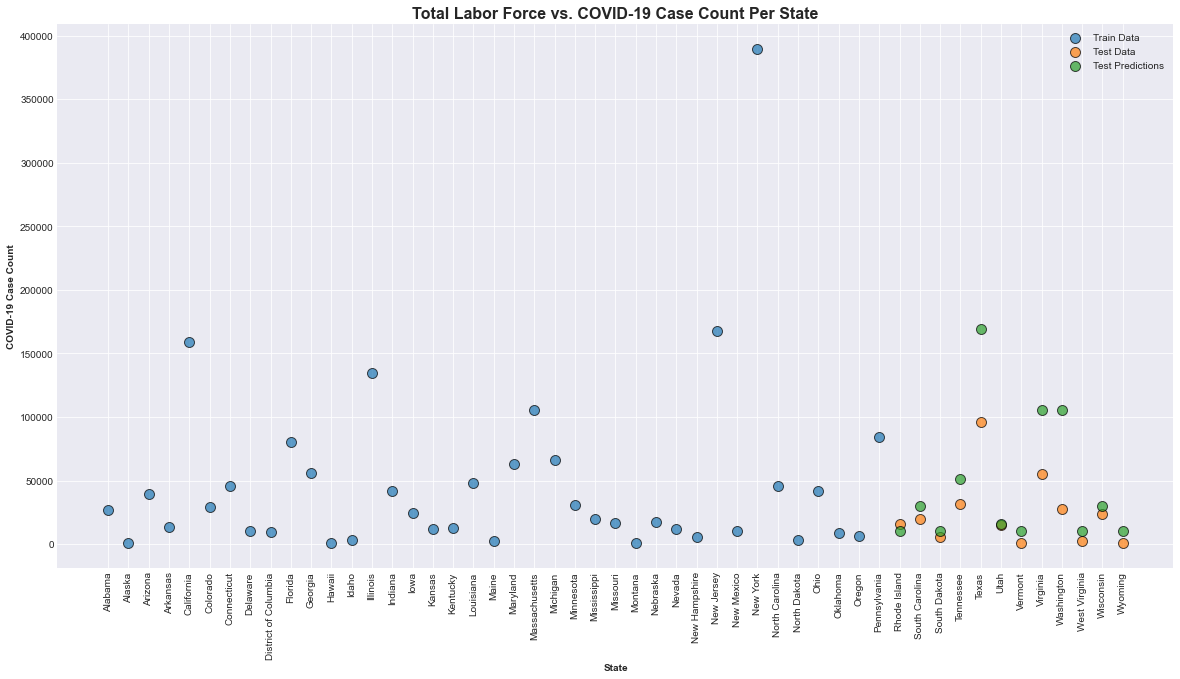

In [73]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Labor Force vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [74]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.22%.


In [75]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7568 degrees.
Accuracy = 94.56%.


In [76]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 3.53%.


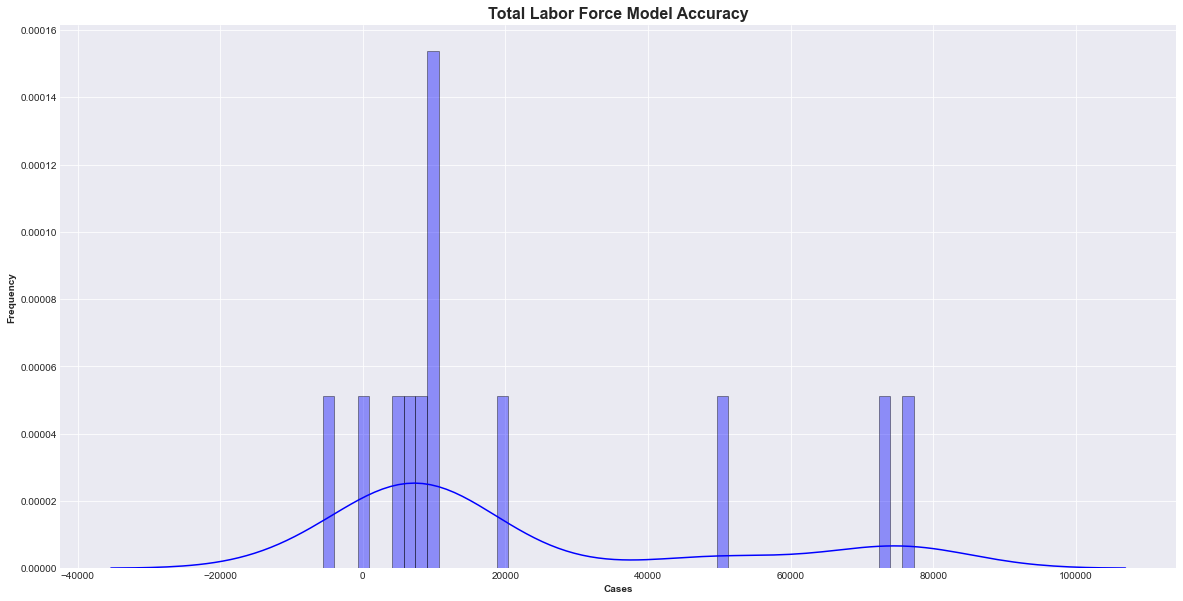

In [77]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Total Labor Force Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Total Doctorate Degrees (2018)

In [78]:
features_list = ['Total Doctorate Degrees 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 121.54891420022035
Train MSE Value: 20100.098618127882
Train RMS Value: 141.77481658647238
Train R2 Score: 0.9999958469332456


Test MAE Value: 52974.16673787435
Test MSE Value: 10595123976.767748
Test RMS Value: 102932.61862387329
Test R2 Score: -14.448609390968821


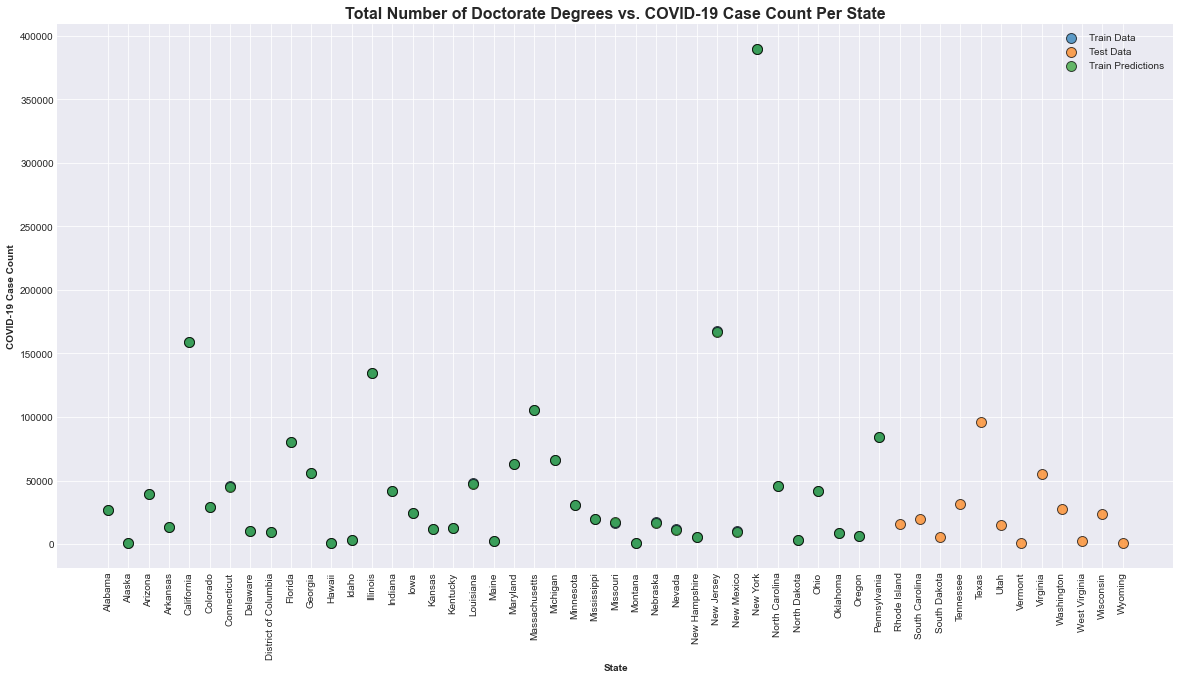

In [79]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Number of Doctorate Degrees vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


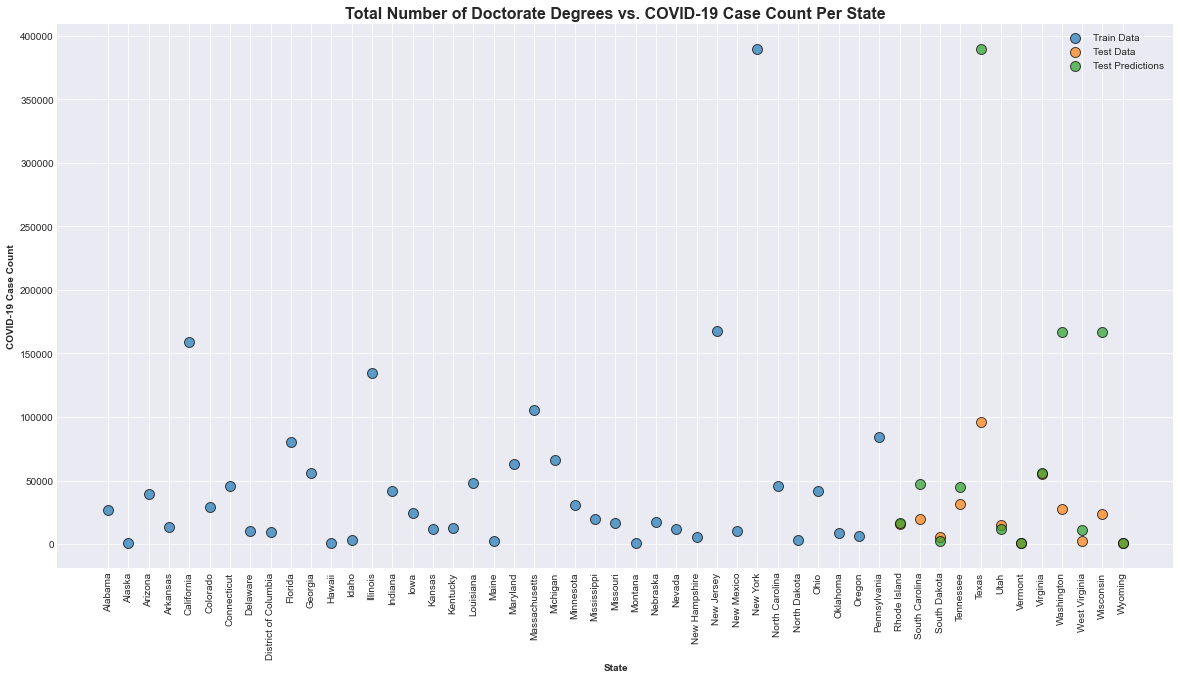

In [80]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Number of Doctorate Degrees vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [81]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.18%.


91.17652263455696

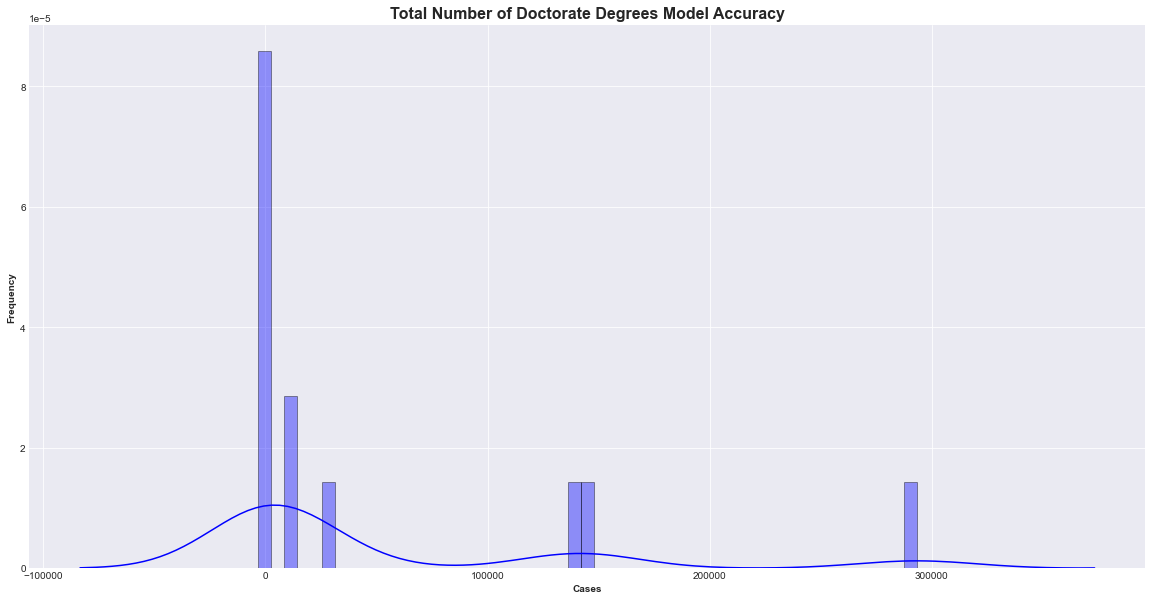

In [82]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Total Number of Doctorate Degrees Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [83]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 2104 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 4368 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 7288 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 10848 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 15064 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 19920 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 25432 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 31584 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 38392 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 45840 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  3.0min finished


In [84]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.07,
 'max_depth': 1,
 'min_child_weight': 2,
 'reg_lambda': 10}

In [85]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 17088.201071714742
Train MSE Value: 1351355108.8293364
Train RMS Value: 36760.78221188086
Train R2 Score: 0.7207840577036002


Test MAE Value: 20228.344401041668
Test MSE Value: 1239572504.6550782
Test RMS Value: 35207.56317405506
Test R2 Score: -0.8074041868874071


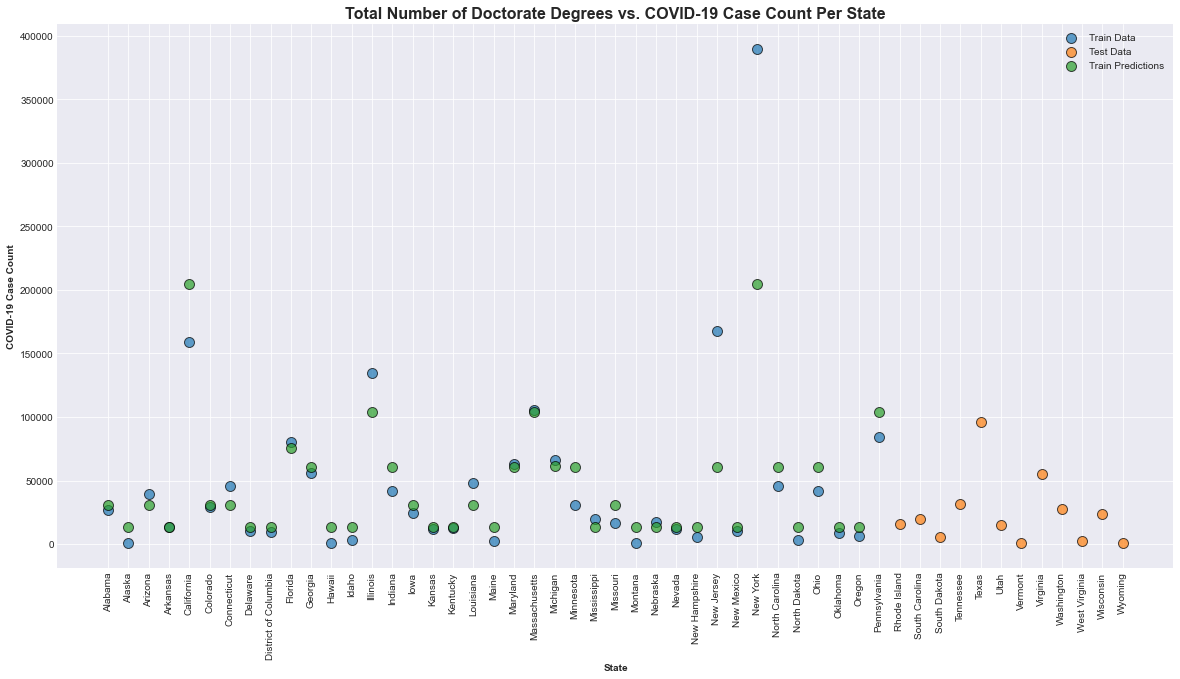

In [86]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Number of Doctorate Degrees vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

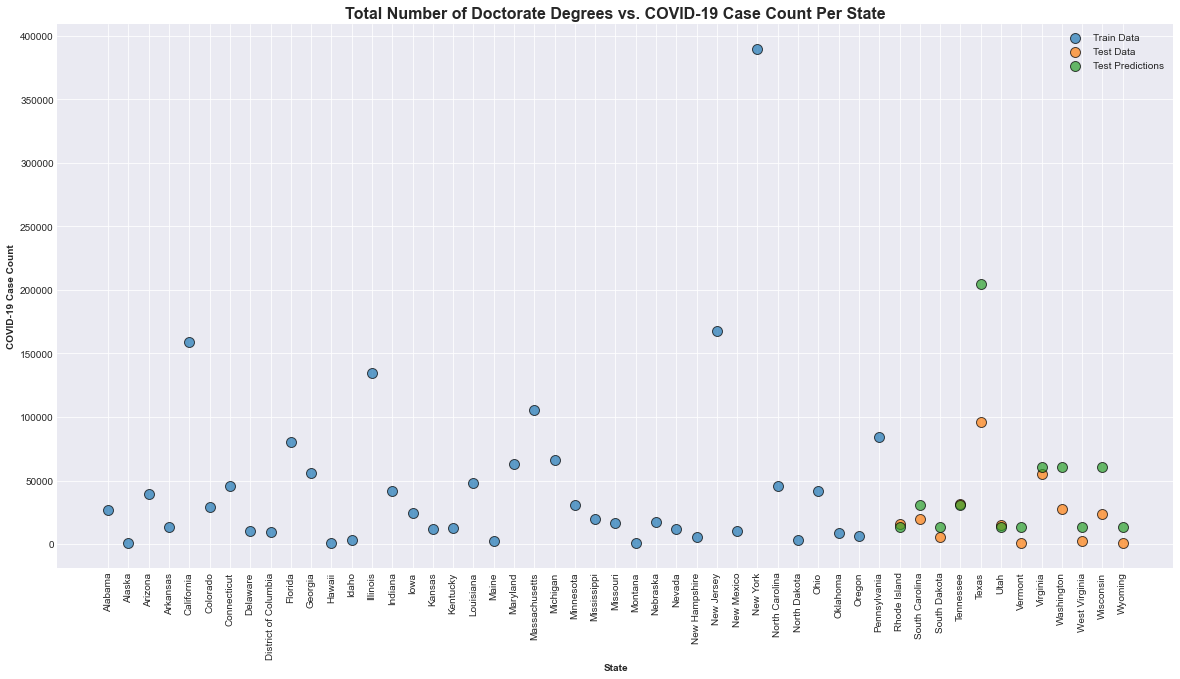

In [87]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Number of Doctorate Degrees vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [88]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.18%.


In [89]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7376 degrees.
Accuracy = 94.09%.


In [90]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 3.09%.


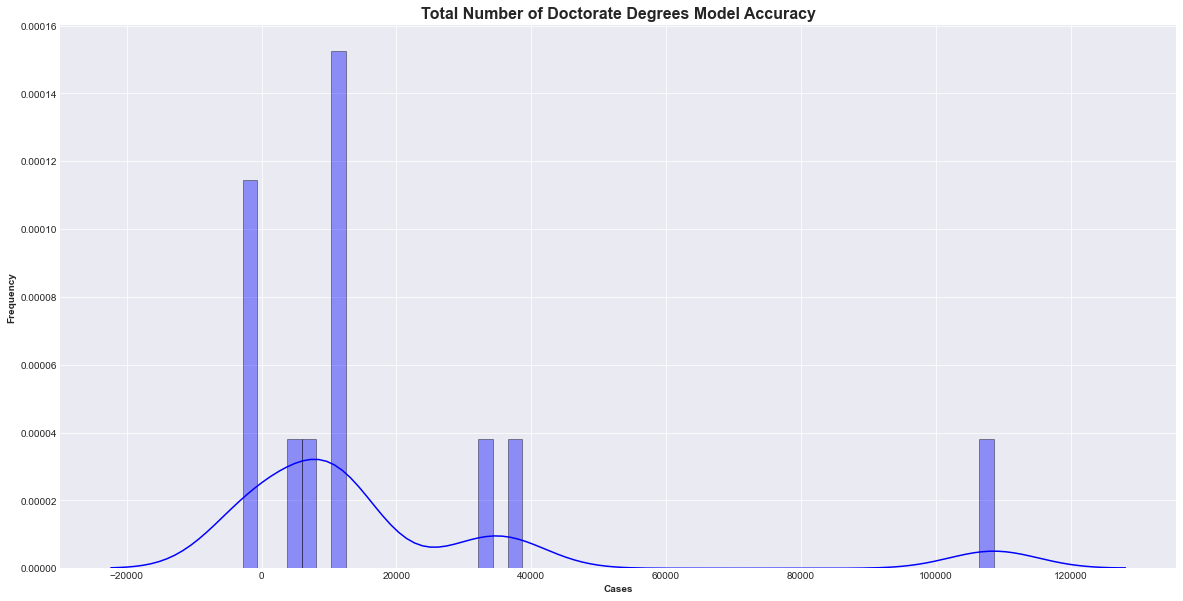

In [91]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Total Number of Doctorate Degrees Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Less than HS Diploma

In [92]:
features_list = ['Less Than HS Diploma 14-18']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 102.45235658303285
Train MSE Value: 14616.964138079435
Train RMS Value: 120.9006374593593
Train R2 Score: 0.9999969798542303


Test MAE Value: 36570.27611796061
Test MSE Value: 7732832160.865414
Test RMS Value: 87936.52347497833
Test R2 Score: -10.275139753067357


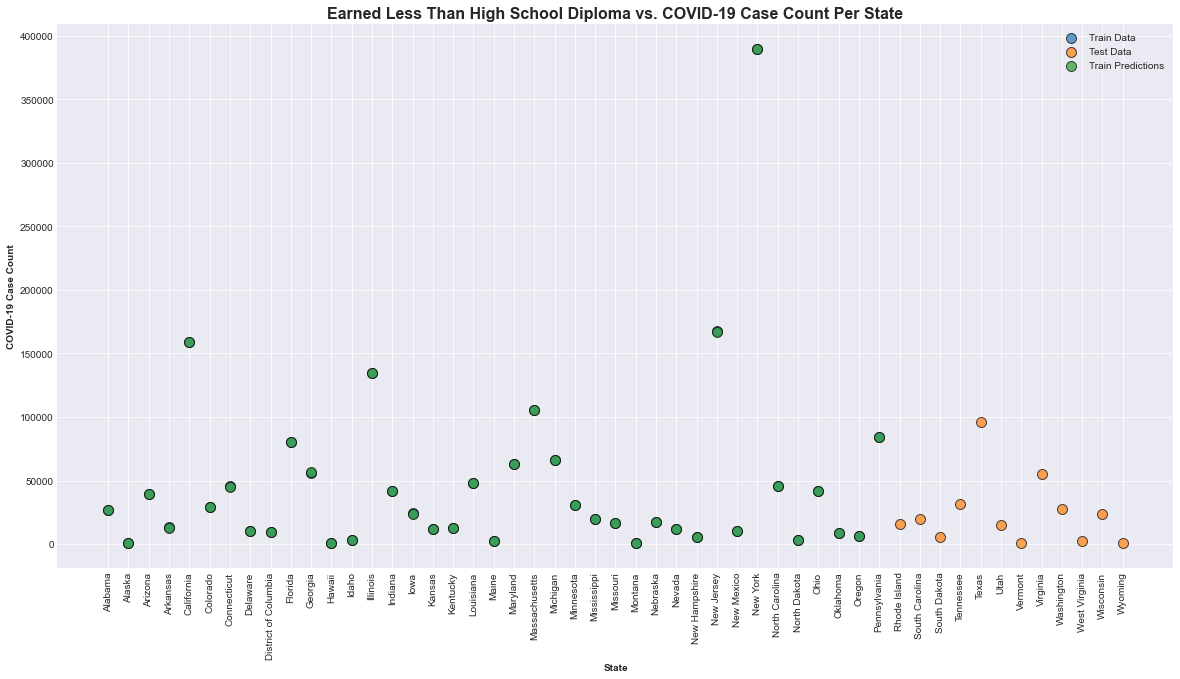

In [93]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Less Than High School Diploma vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


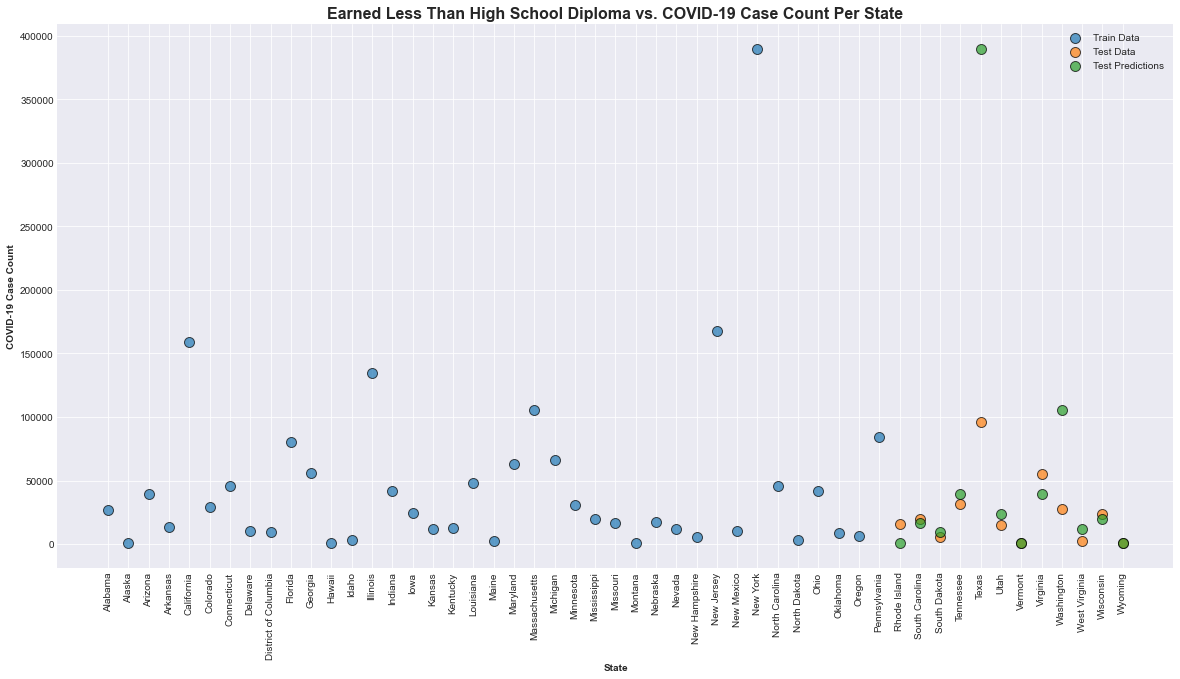

In [94]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Less Than High School Diploma vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [95]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.22%.


91.22482096608191

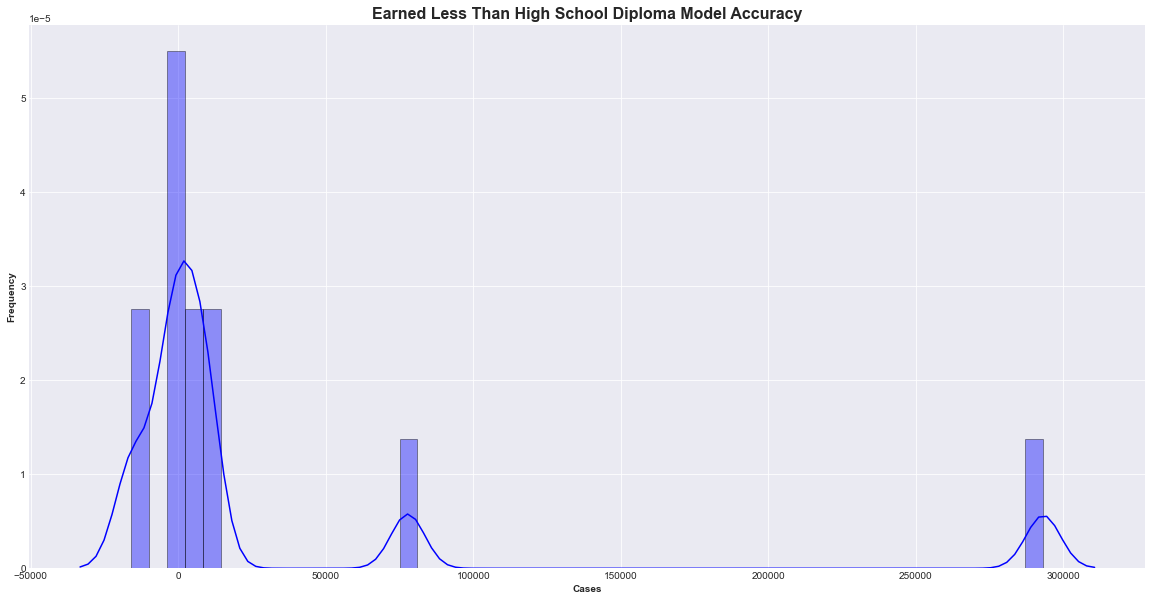

In [96]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Earned Less Than High School Diploma Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [97]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2060 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 4652 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 6432 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 8540 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 10968 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 13724 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 16800 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 21280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 28728 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 36832 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 45576 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 50400 o

In [98]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.06,
 'max_depth': 1,
 'min_child_weight': 3,
 'reg_lambda': 10}

In [99]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 22277.885516826922
Train MSE Value: 1925795351.793015
Train RMS Value: 43883.88487580623
Train R2 Score: 0.6020936611645122


Test MAE Value: 15540.026692708334
Test MSE Value: 597105427.108436
Test RMS Value: 24435.74077265586
Test R2 Score: 0.12936851622948797


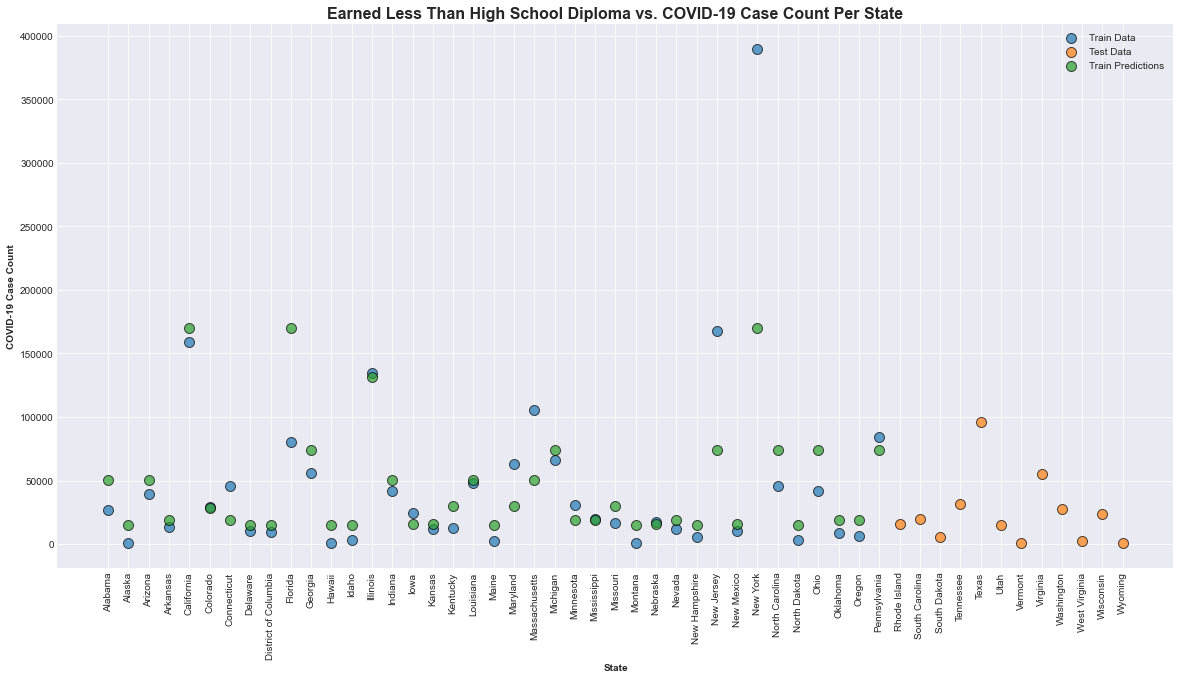

In [100]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Less Than High School Diploma vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

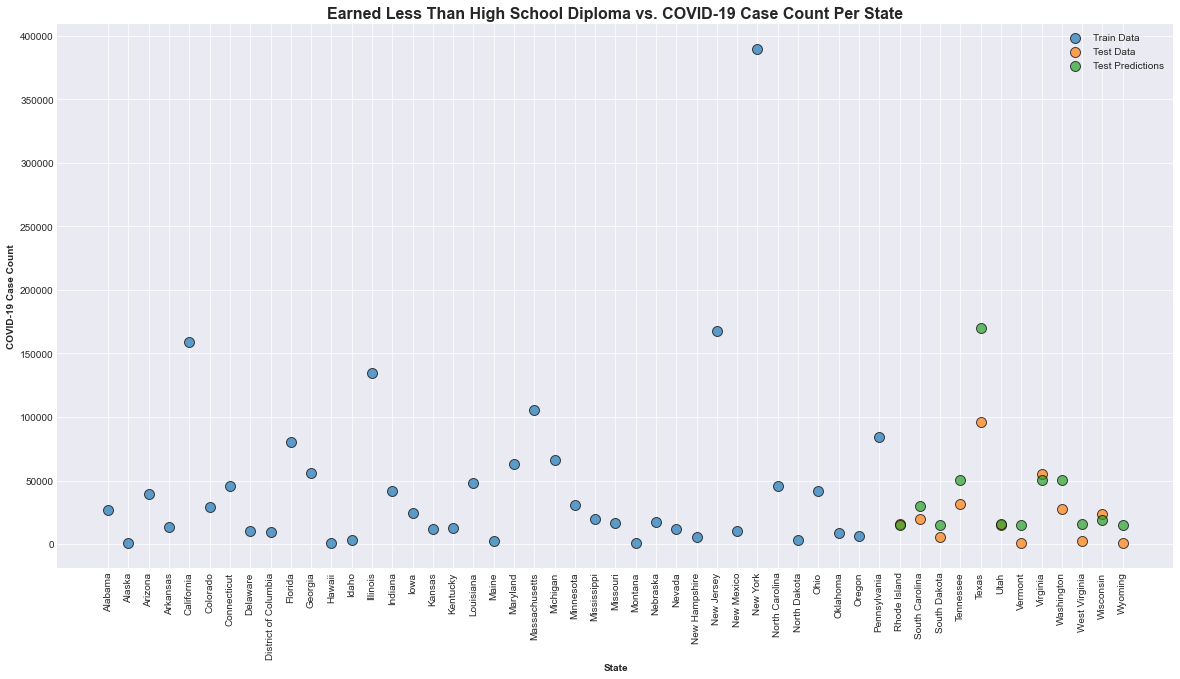

In [101]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Less Than High School Diploma vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [102]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.22%.


In [103]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7368 degrees.
Accuracy = 96.20%.


In [104]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 5.18%.


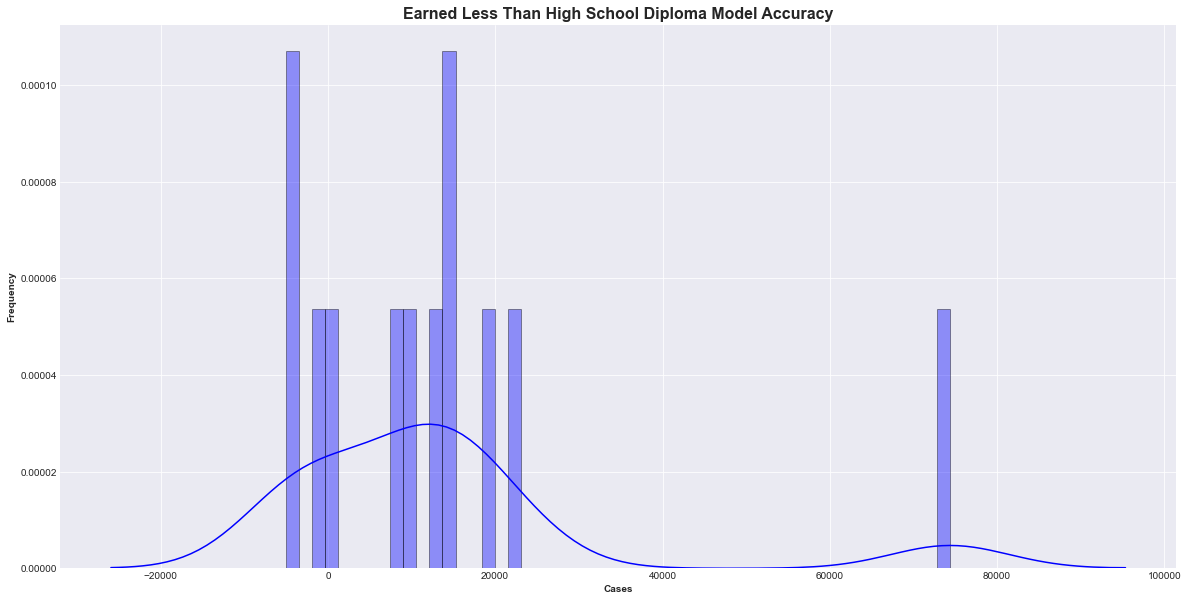

In [105]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Earned Less Than High School Diploma Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## HS Diploma

In [106]:
features_list = ['HS Diploma 14-18']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 113.34226794120593
Train MSE Value: 18198.061206731563
Train RMS Value: 134.90018979501684
Train R2 Score: 0.9999962399307373


Test MAE Value: 7714.2047119140625
Test MSE Value: 77175641.36224556
Test RMS Value: 8784.966782079802
Test R2 Score: 0.8874712235064804


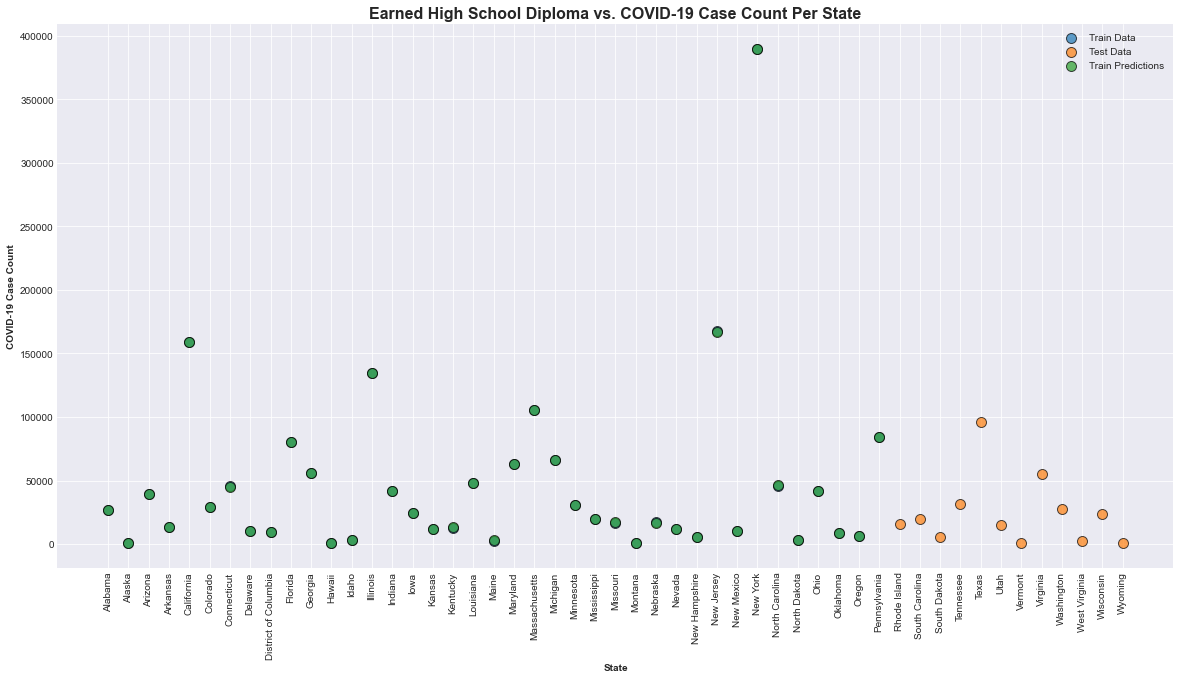

In [107]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned High School Diploma vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

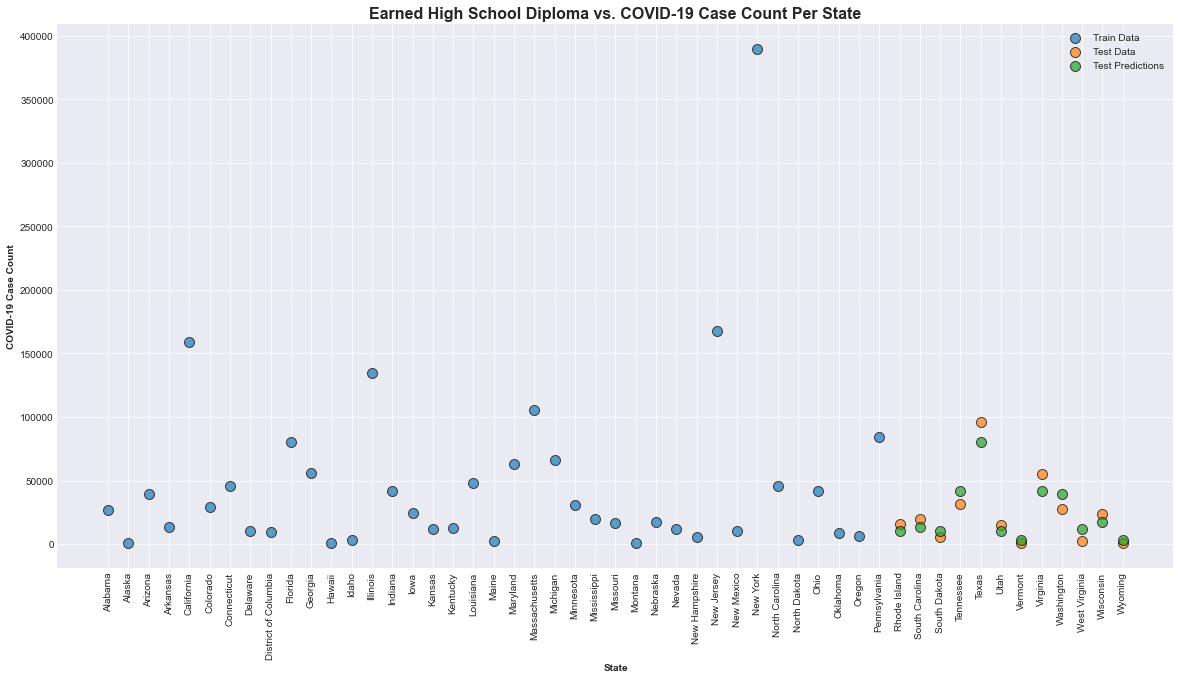

In [108]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned High School Diploma vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [109]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8307 degrees.
Accuracy = 91.28%.


91.2778512582571

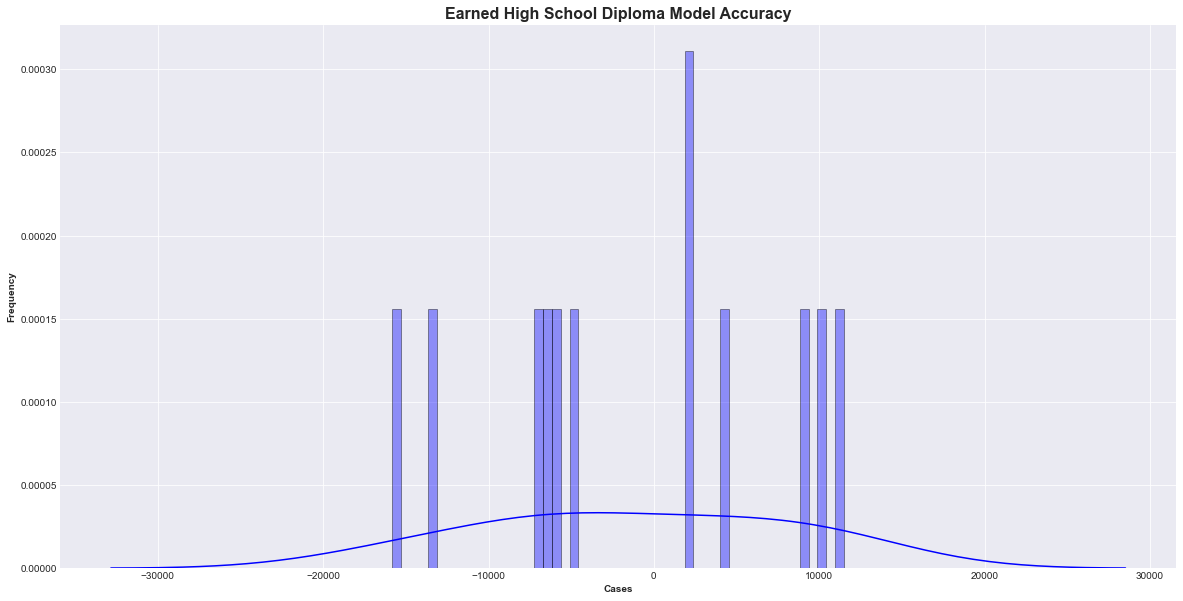

In [110]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Earned High School Diploma Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [111]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3692 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 5616 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 8536 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 12096 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 16312 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 21168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 26680 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 32832 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 39640 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 47088 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.8min finished


In [112]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 1,
 'min_child_weight': 3,
 'reg_lambda': 10}

In [113]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 23387.83653846154
Train MSE Value: 2055174782.179506
Train RMS Value: 45334.03558232496
Train R2 Score: 0.5753613838133502


Test MAE Value: 16494.24462890625
Test MSE Value: 554734816.5645825
Test RMS Value: 23552.809101348877
Test R2 Score: 0.1911485400766979


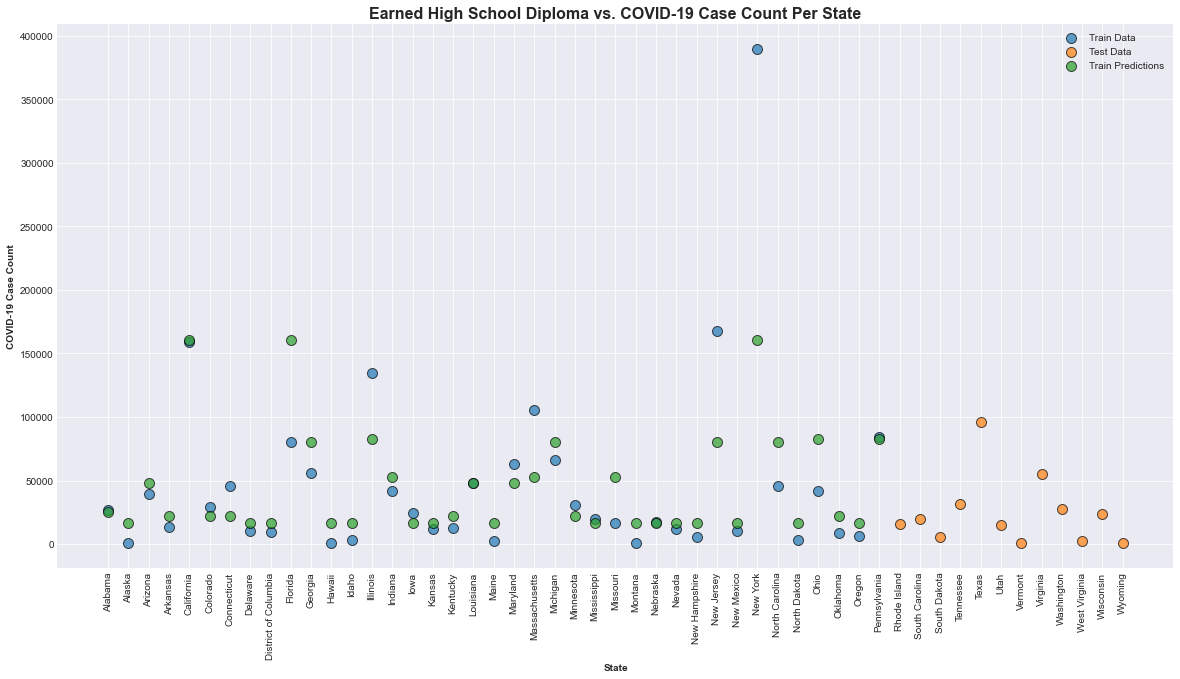

In [114]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned High School Diploma vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

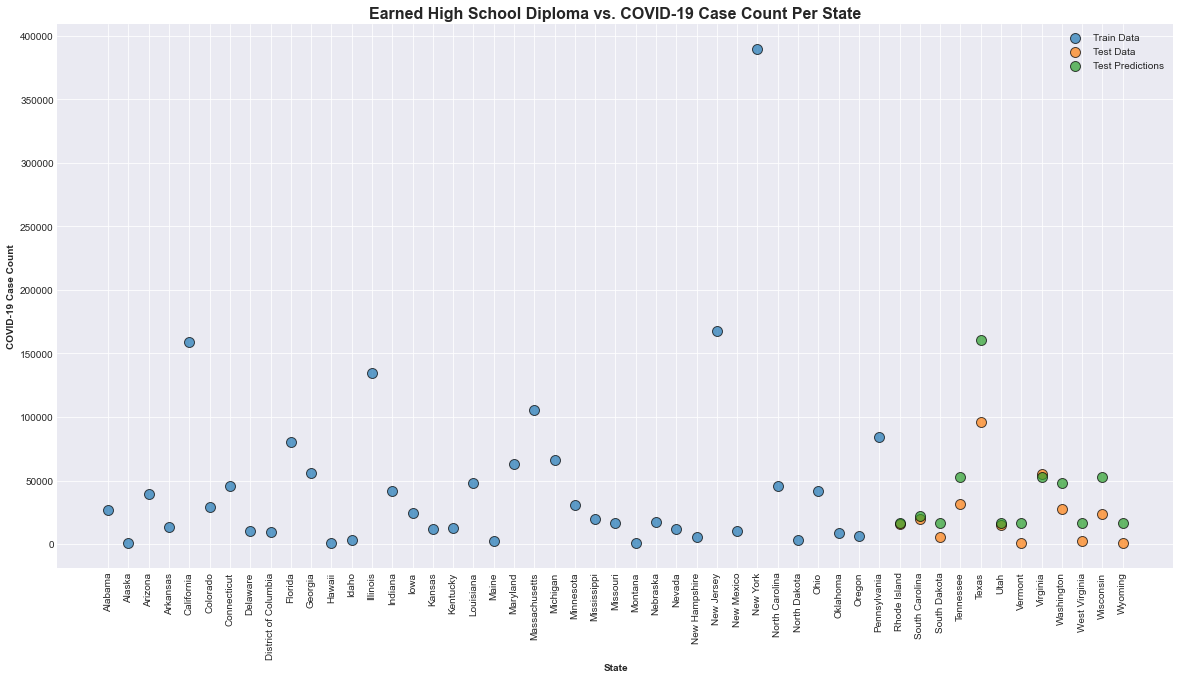

In [115]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned High School Diploma vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [116]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8307 degrees.
Accuracy = 91.28%.


In [117]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7242 degrees.
Accuracy = 98.72%.


In [118]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 7.54%.


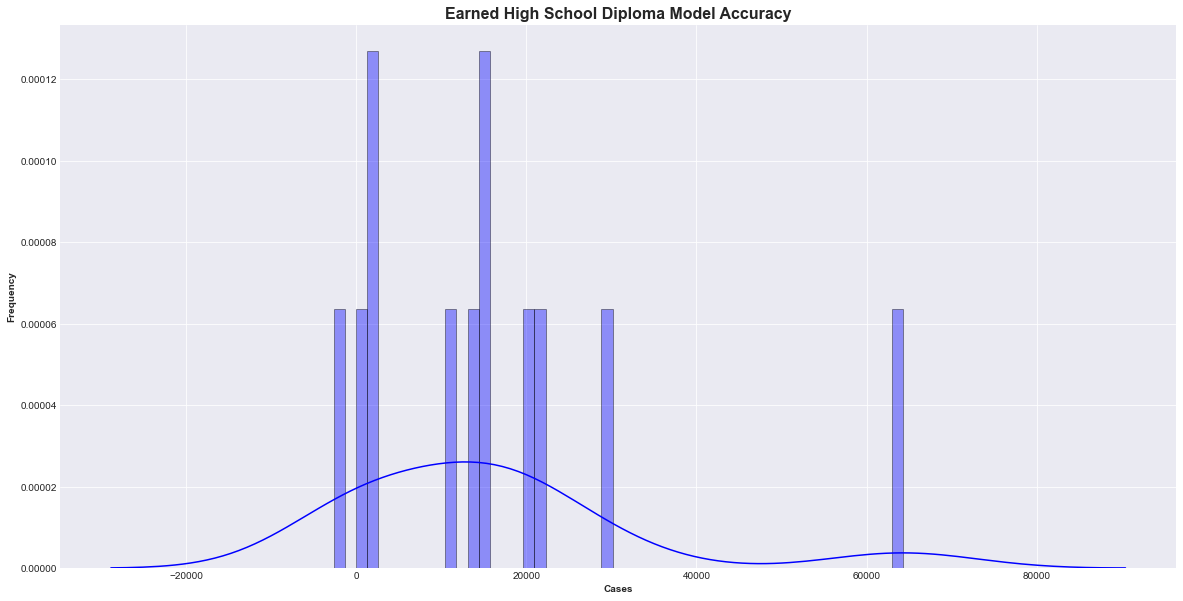

In [119]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Earned High School Diploma Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Some College or Associate Degree

In [120]:
features_list = ['Some College or Associate Degree 14-18']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 105.59389554537259
Train MSE Value: 15064.236790766605
Train RMS Value: 122.73645257529078
Train R2 Score: 0.9999968874391024


Test MAE Value: 11165.14576212565
Test MSE Value: 242893374.12405562
Test RMS Value: 15585.036866304026
Test R2 Score: 0.6458404008556282


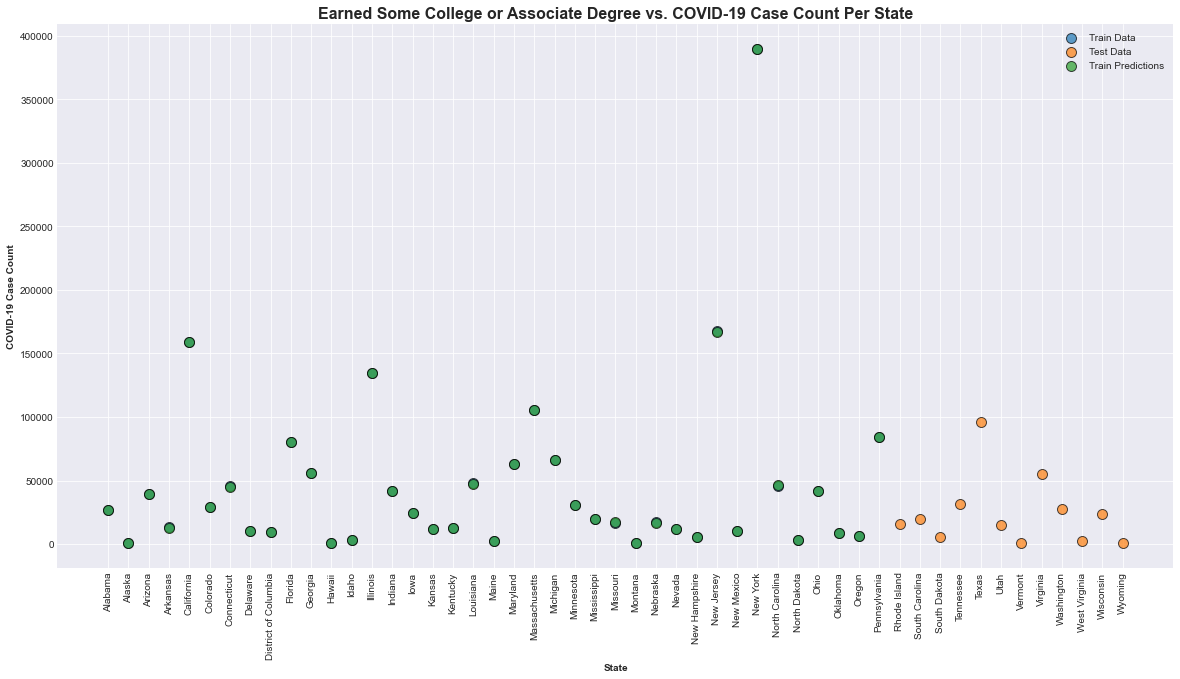

In [121]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Some College or Associate Degree vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

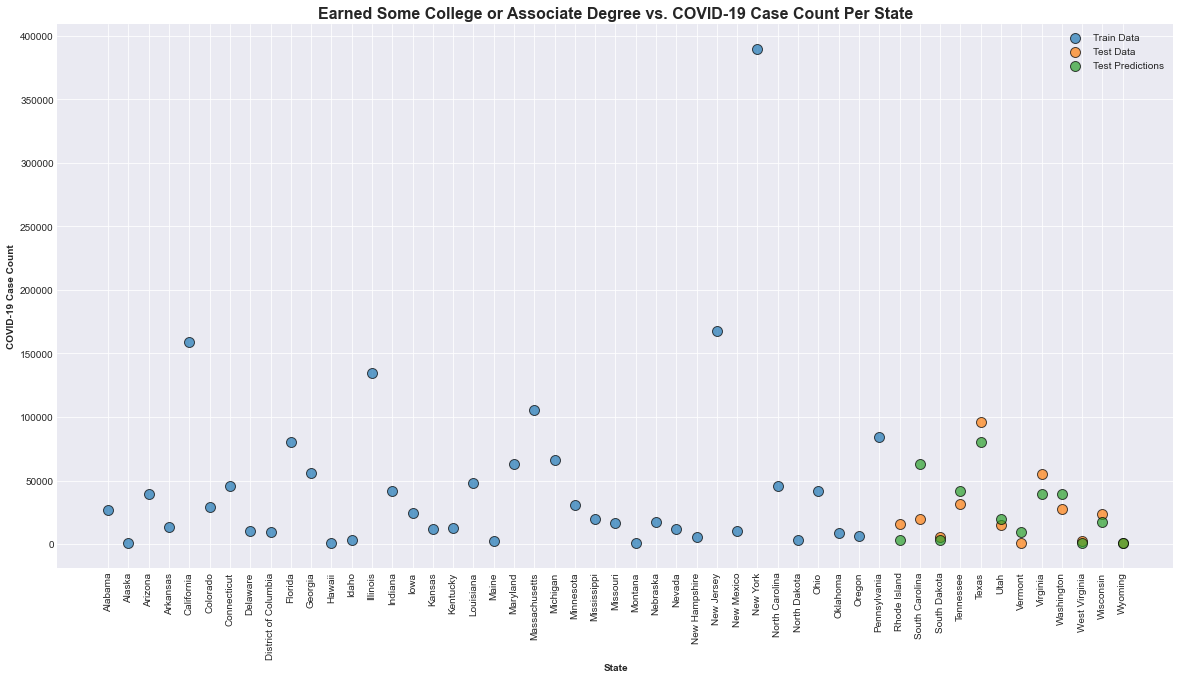

In [122]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Some College or Associate Degree vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [123]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8307 degrees.
Accuracy = 91.24%.


91.23586551051561

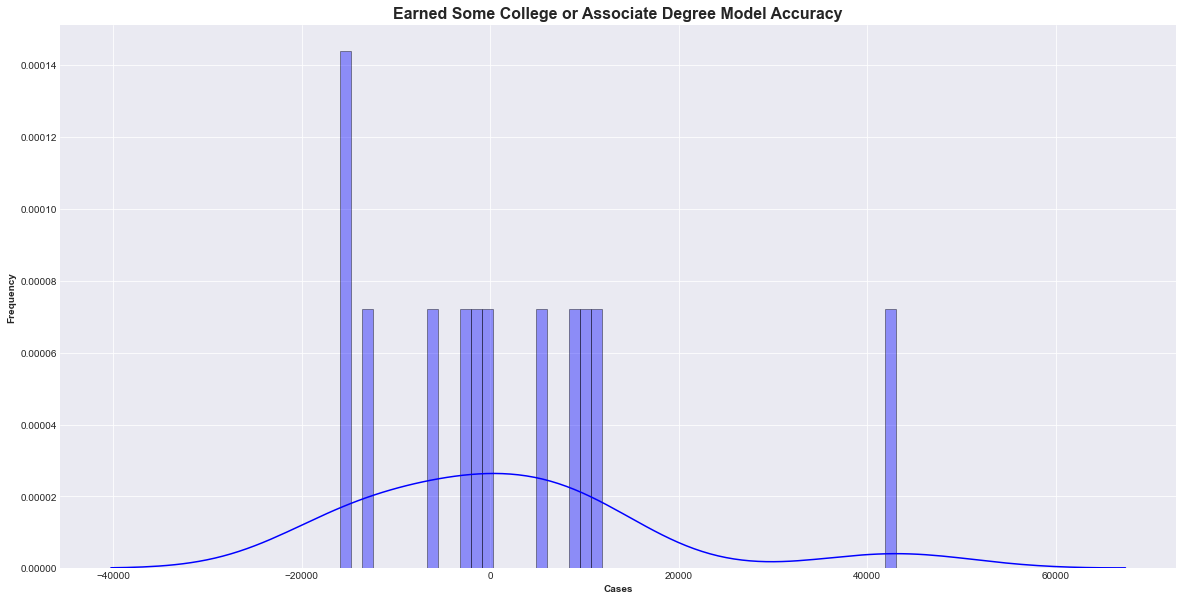

In [124]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Earned Some College or Associate Degree Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [125]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 9160 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 12720 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 16936 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 21792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 27304 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 33456 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 40264 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 45360 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 49412 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  3.0min finished


In [126]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 2,
 'reg_lambda': 10}

In [127]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 18537.758563701922
Train MSE Value: 1567685666.3694324
Train RMS Value: 39594.01048604994
Train R2 Score: 0.6760860060394527


Test MAE Value: 21797.164713541668
Test MSE Value: 824080087.9615326
Test RMS Value: 28706.795153091065
Test R2 Score: -0.20158021875990872


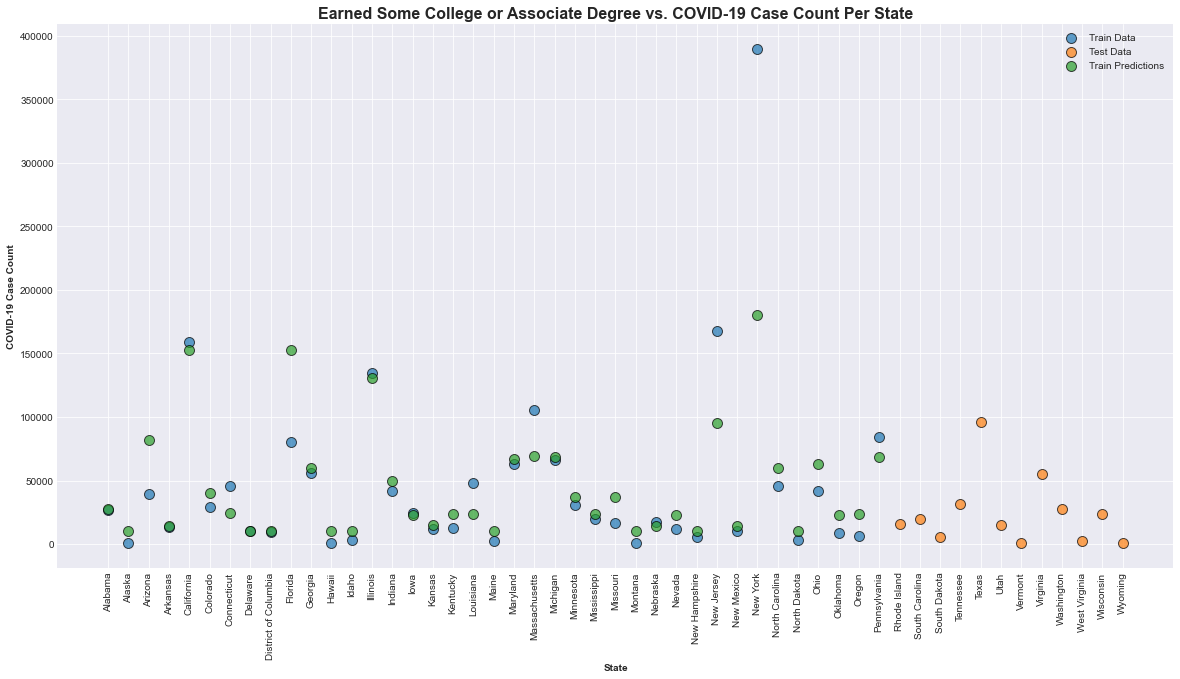

In [128]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Some College or Associate Degree vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

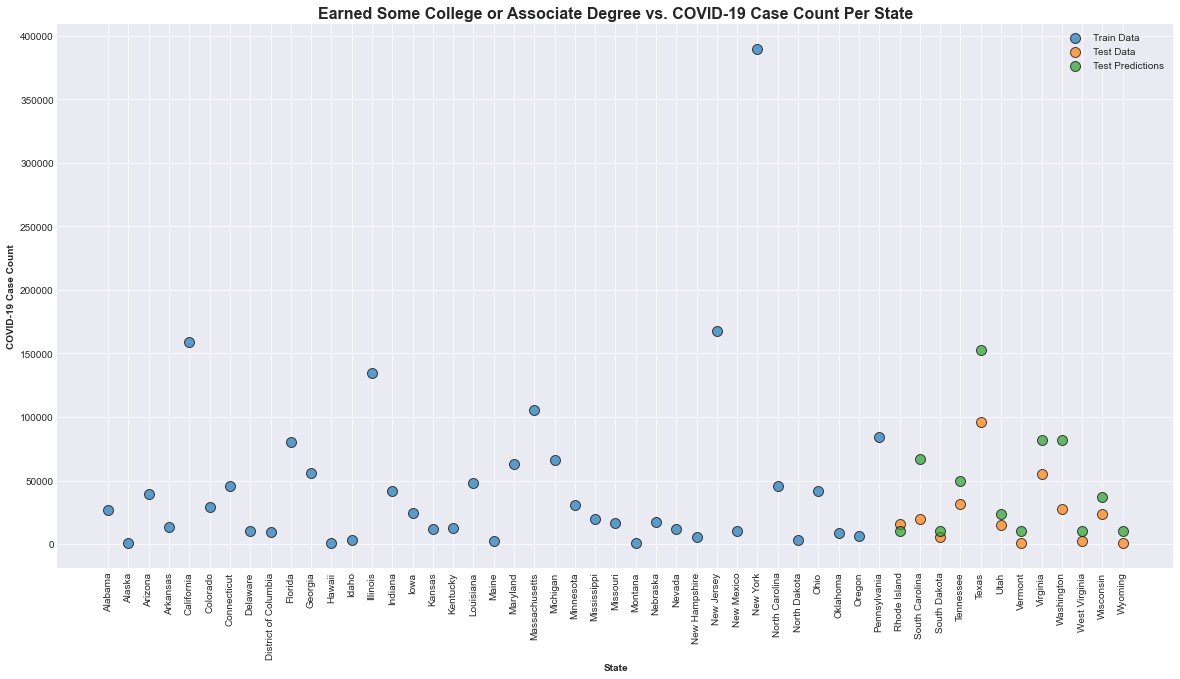

In [129]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Some College or Associate Degree vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [130]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8307 degrees.
Accuracy = 91.24%.


In [131]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7394 degrees.
Accuracy = 96.88%.


In [132]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 5.83%.


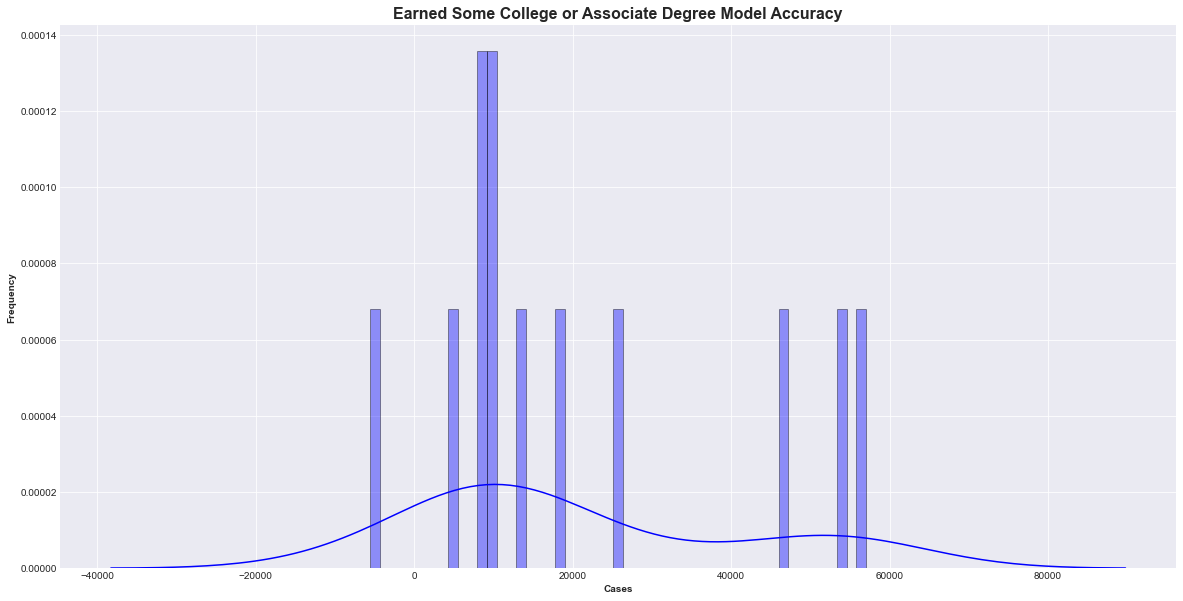

In [133]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Earned Some College or Associate Degree Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Bachelor Degree or Higher

In [134]:
features_list = ['Bachelor Degree or Higher 14-18']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 99.46251032902644
Train MSE Value: 15496.33220104023
Train RMS Value: 124.48426487327717
Train R2 Score: 0.9999967981598845


Test MAE Value: 35399.54240926107
Test MSE Value: 7375970091.261617
Test RMS Value: 85883.46809055639
Test R2 Score: -9.754803914444766


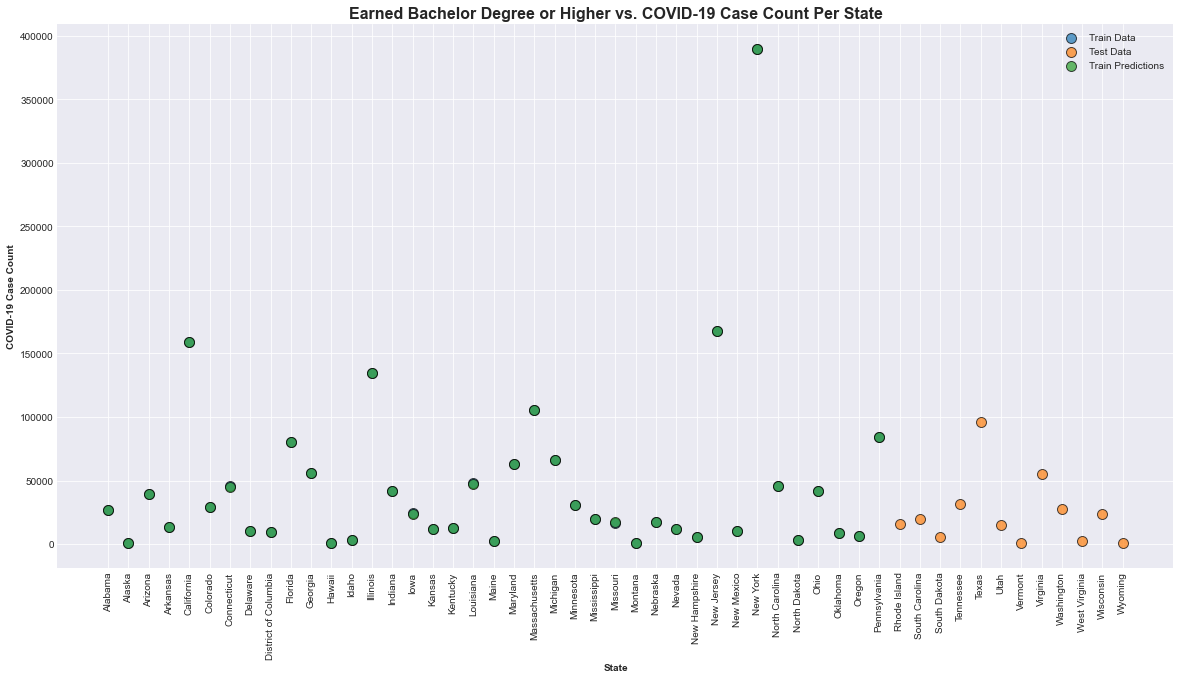

In [135]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Bachelor Degree or Higher vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

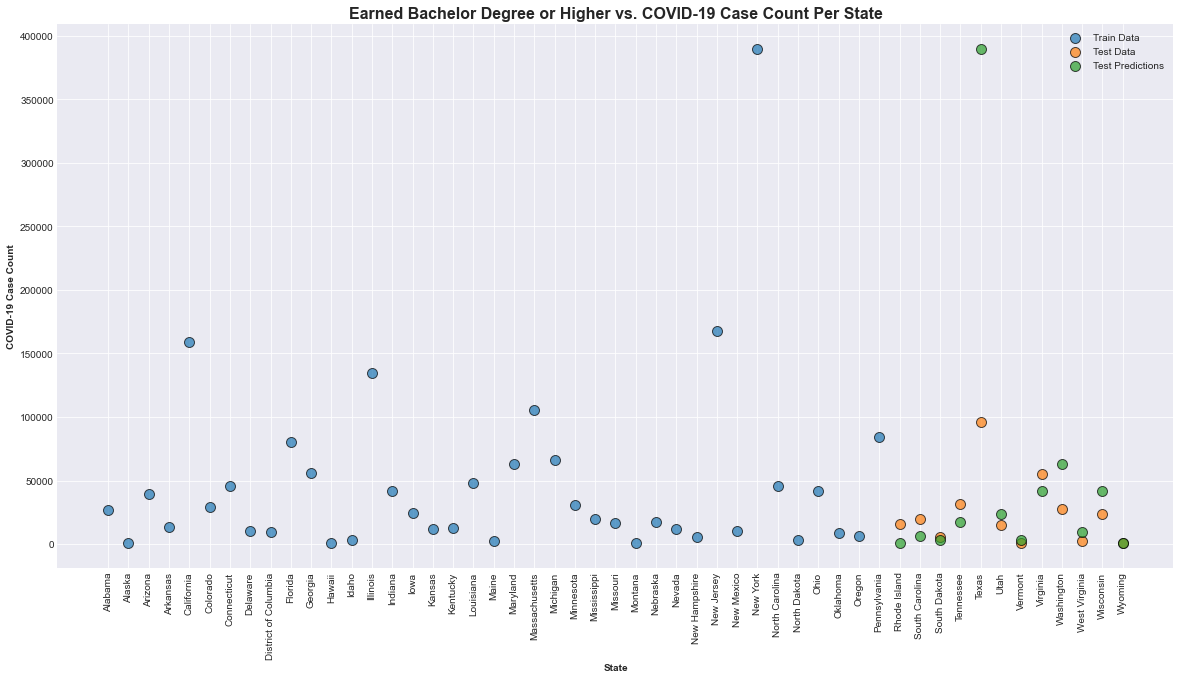

In [136]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Bachelor Degree or Higher vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [137]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.18%.


91.18384873141163

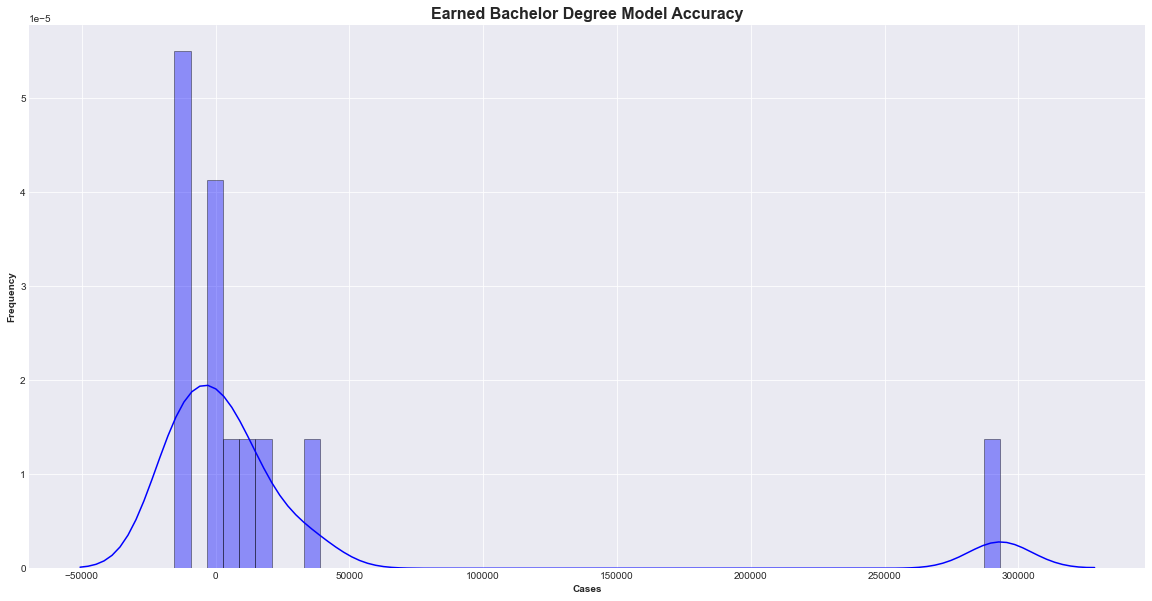

In [138]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Earned Bachelor Degree Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [139]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 8808 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 14648 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 21768 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 30200 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 36960 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 42472 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 48624 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.6min finished


In [140]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 2,
 'reg_lambda': 10}

In [141]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 15710.920022035256
Train MSE Value: 1255136670.48682
Train RMS Value: 35427.90807381689
Train R2 Score: 0.7406646366517697


Test MAE Value: 15742.209798177084
Test MSE Value: 889217303.3990723
Test RMS Value: 29819.74687013745
Test R2 Score: -0.29655592648323825


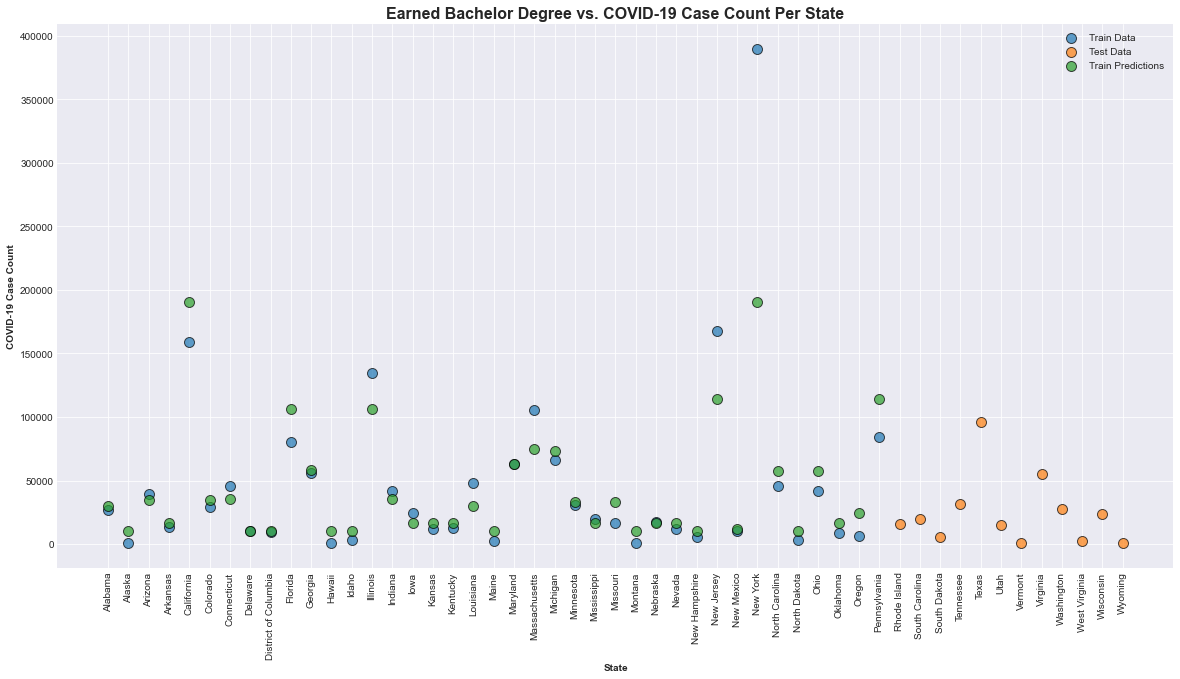

In [142]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Bachelor Degree vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

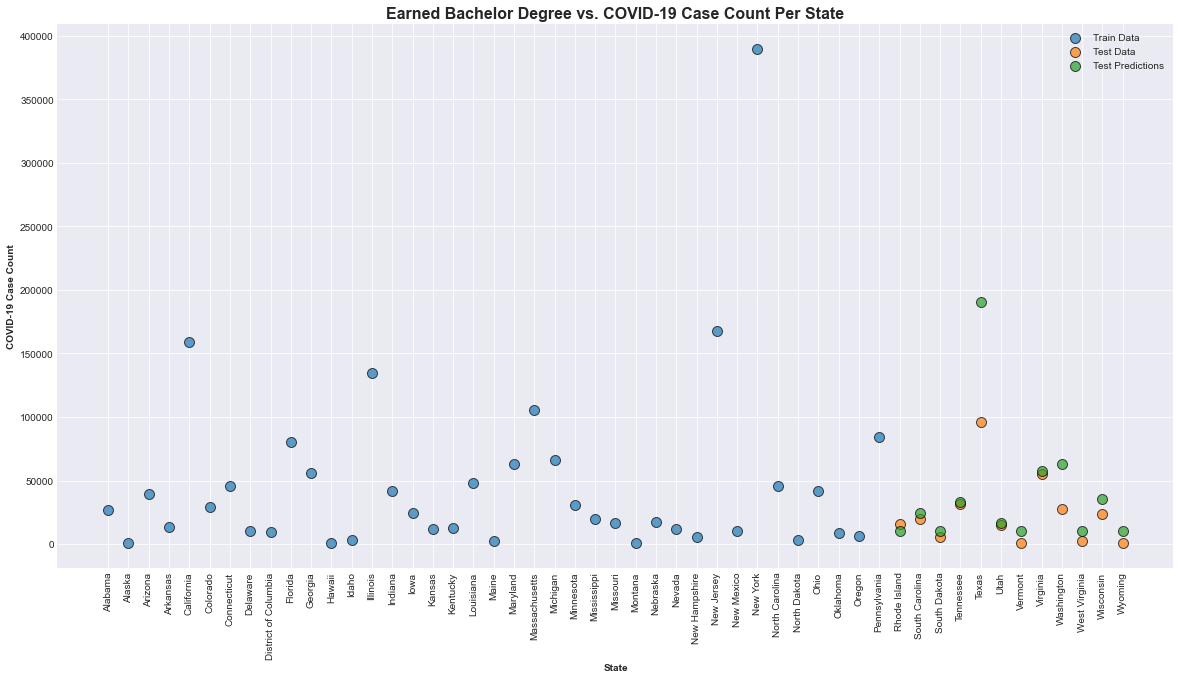

In [143]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Earned Bachelor Degree vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [144]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.18%.


In [145]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7426 degrees.
Accuracy = 90.98%.


In [146]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of -0.22%.


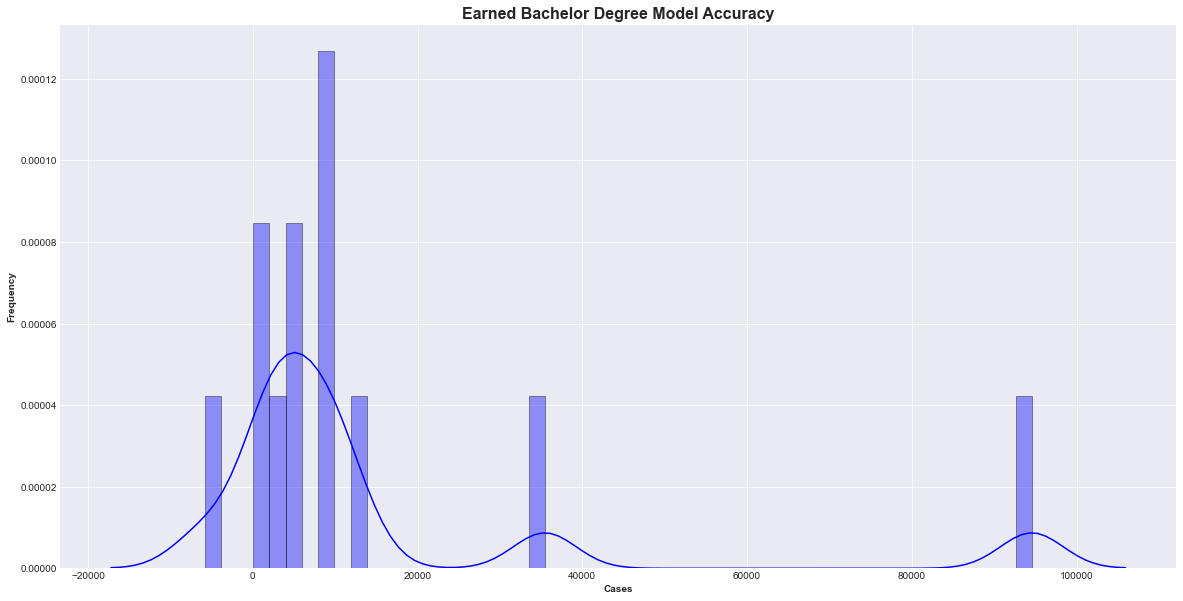

In [147]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Earned Bachelor Degree Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## ELL Students Enrolled

In [148]:
features_list = ['ELL Students Enrolled 2017']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 95.52725141476363
Train MSE Value: 15919.502297229777
Train RMS Value: 126.17251006946711
Train R2 Score: 0.9999967107248082


Test MAE Value: 12133.30510965983
Test MSE Value: 453185772.55599374
Test RMS Value: 21288.16038449527
Test R2 Score: 0.33921585088447403


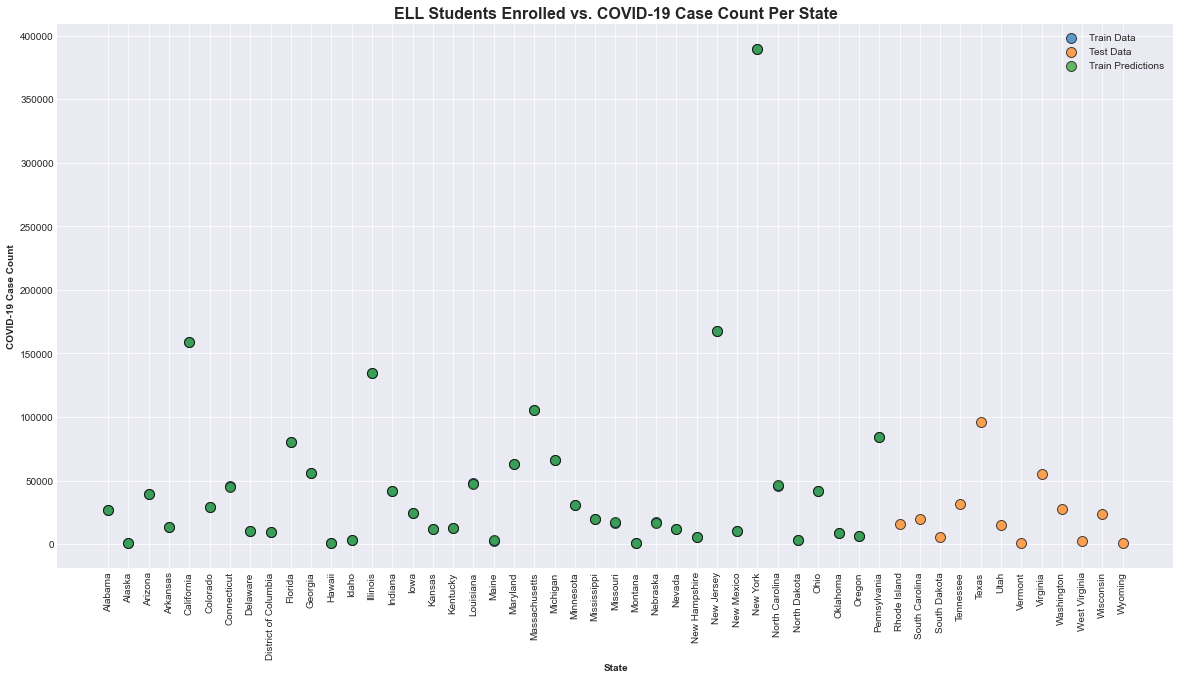

In [149]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('ELL Students Enrolled vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

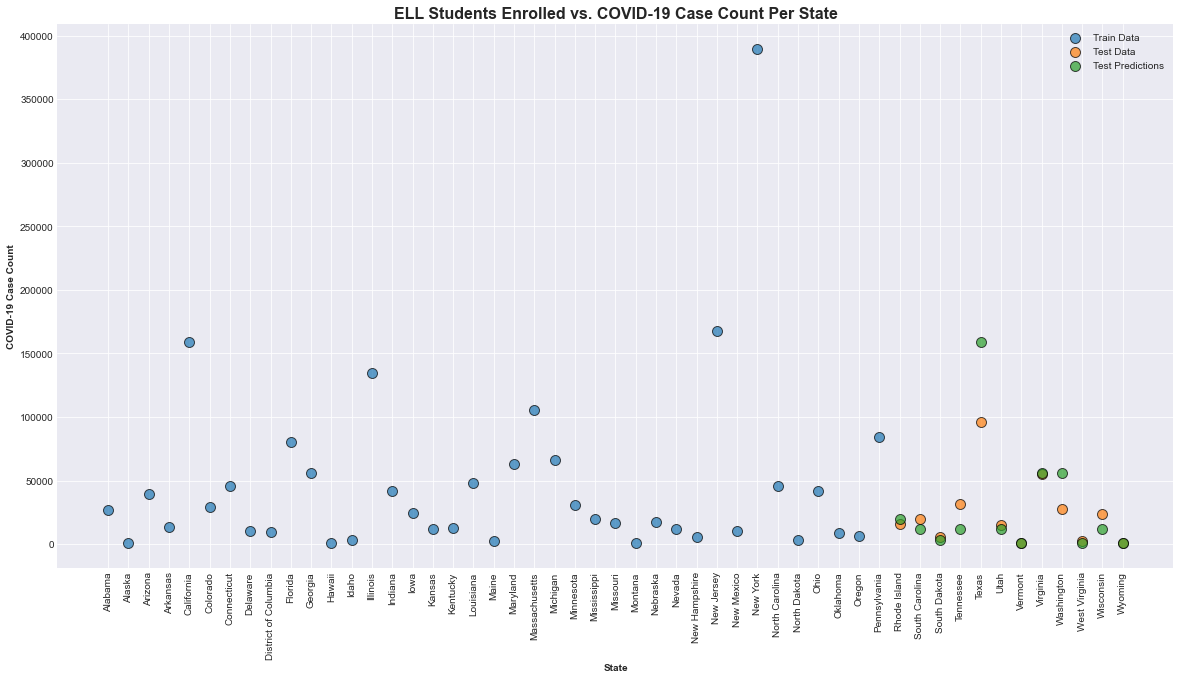

In [150]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('ELL Students Enrolled vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [151]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8307 degrees.
Accuracy = 91.17%.


91.1717499769582

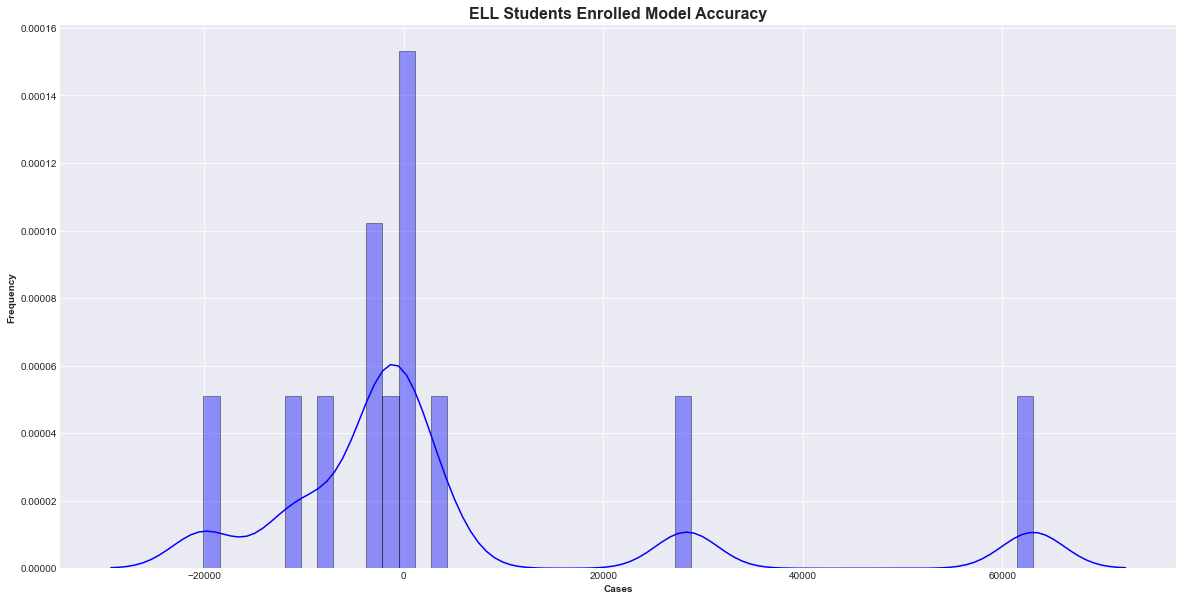

In [152]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('ELL Students Enrolled Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [153]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 7504 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 11064 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 15280 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 20136 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 25648 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 31800 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 38608 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 46056 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 50377 out of 50400 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.8min finished


In [154]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 1,
 'min_child_weight': 3,
 'reg_lambda': 10}

In [155]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 23261.19391025641
Train MSE Value: 2083387111.1553023
Train RMS Value: 45644.135561485906
Train R2 Score: 0.5695321743273425


Test MAE Value: 15907.559895833334
Test MSE Value: 559403233.8380941
Test RMS Value: 23651.70678488329
Test R2 Score: 0.18434158292445757


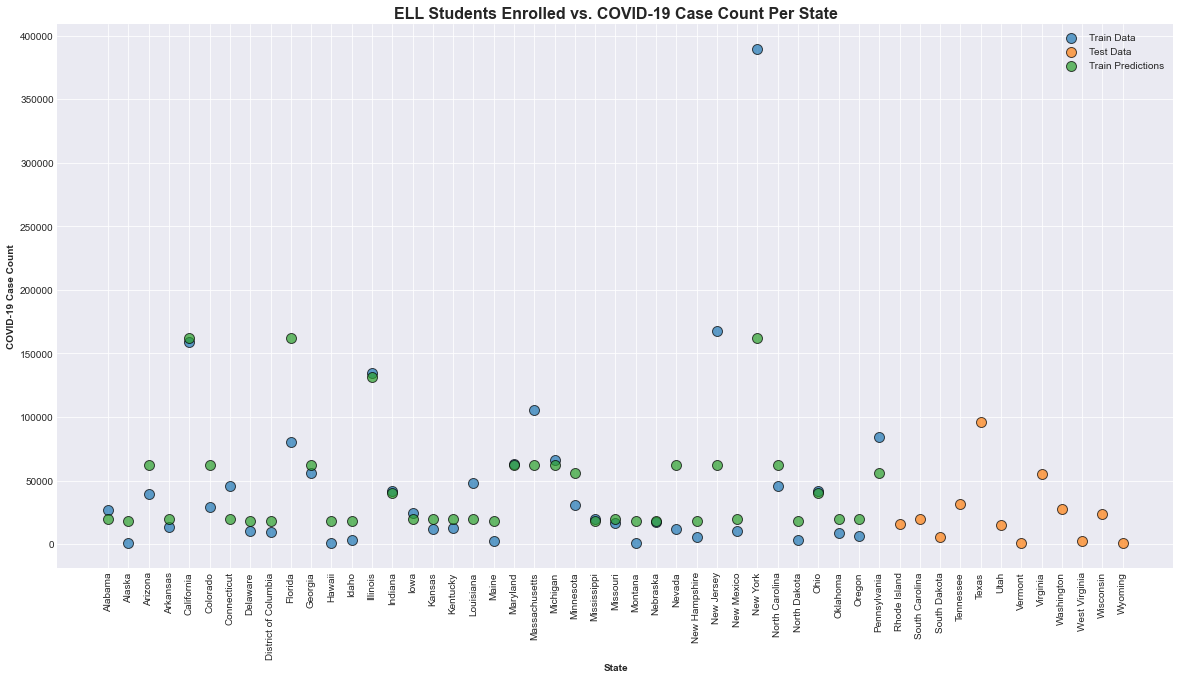

In [156]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('ELL Students Enrolled vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

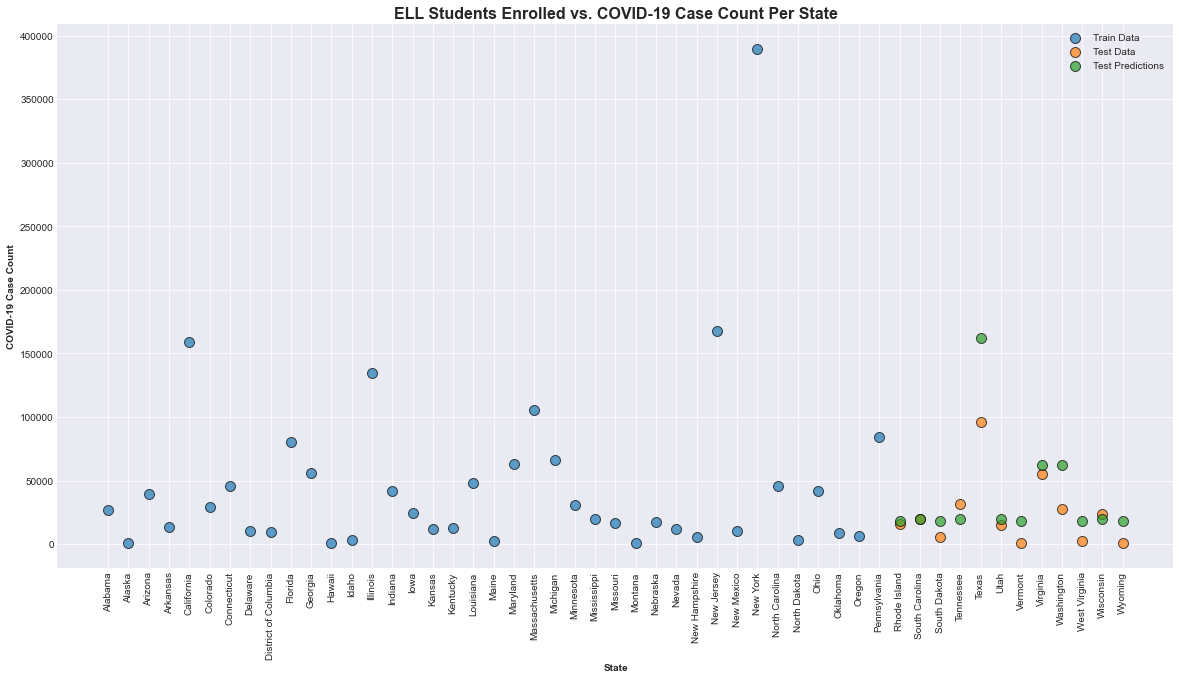

In [157]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('ELL Students Enrolled vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [158]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8307 degrees.
Accuracy = 91.17%.


In [159]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7198 degrees.
Accuracy = 99.10%.


In [160]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 8.00%.


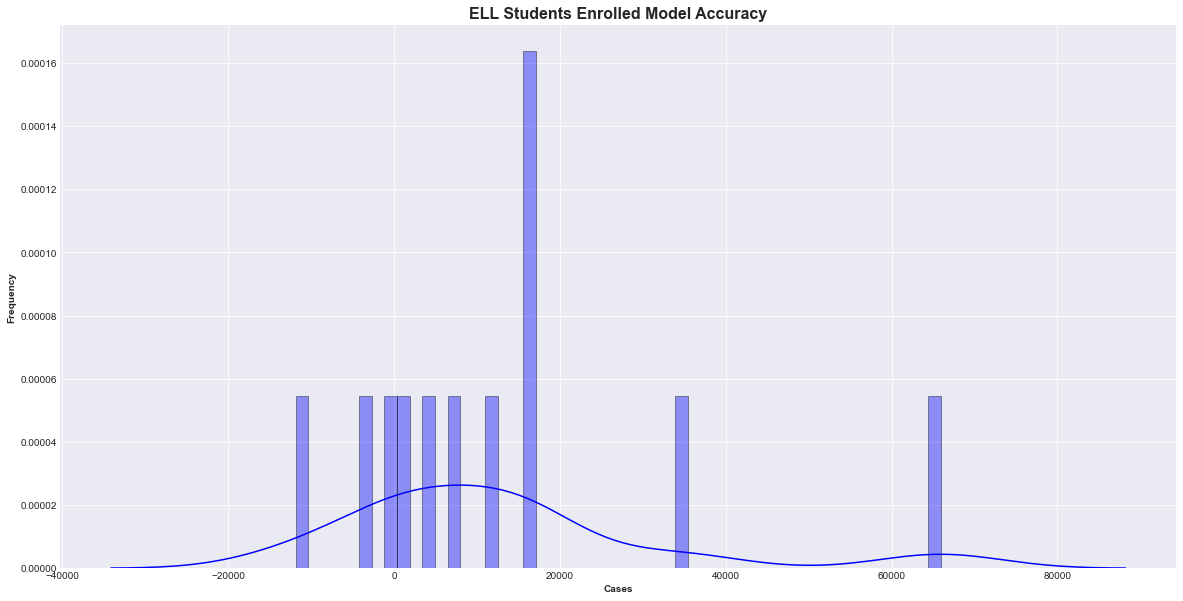

In [161]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('ELL Students Enrolled Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Overall Literacy

In [162]:
features_list = ['4th 2015 Math', '4th 2015 Science', '8th 2015 Math', '8th 2015 Science', 
                 'Labor Force Participants 2018', 'Total Doctorate Degrees 2018', 'Less Than HS Diploma 14-18',
                 'HS Diploma 14-18', 'Some College or Associate Degree 14-18', 'Bachelor Degree or Higher 14-18',
                 'ELL Students Enrolled 2017']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 36.07393861428285
Train MSE Value: 2625.030247504417
Train RMS Value: 51.23504901436532
Train R2 Score: 0.9999994576182905


Test MAE Value: 19851.697530110676
Test MSE Value: 2634674772.7140303
Test RMS Value: 51329.08310805902
Test R2 Score: -2.8415842537706273


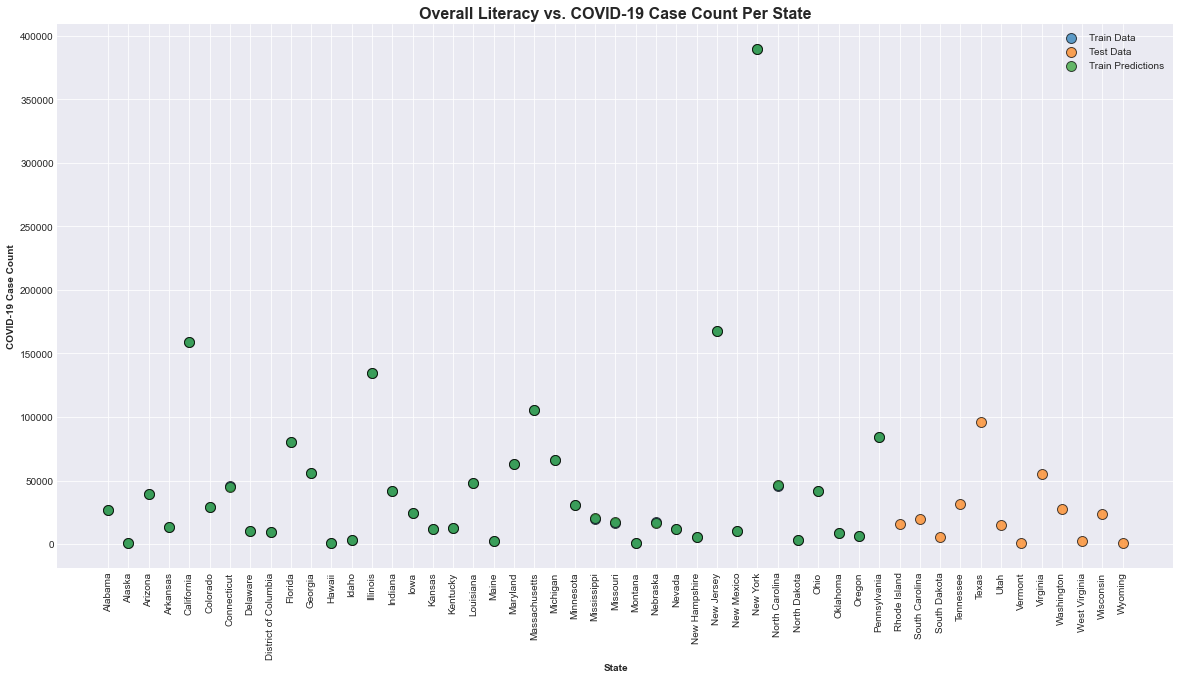

In [163]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Literacy vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

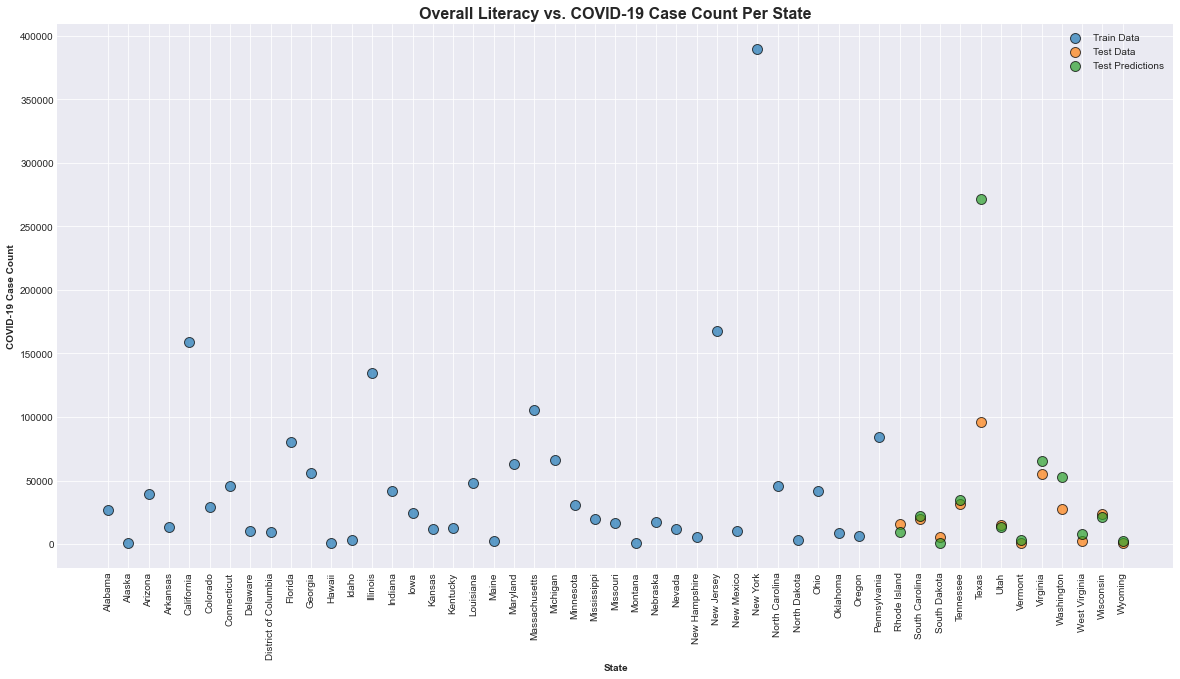

In [164]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Literacy vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [165]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8310 degrees.
Accuracy = 91.24%.


91.24065045059899

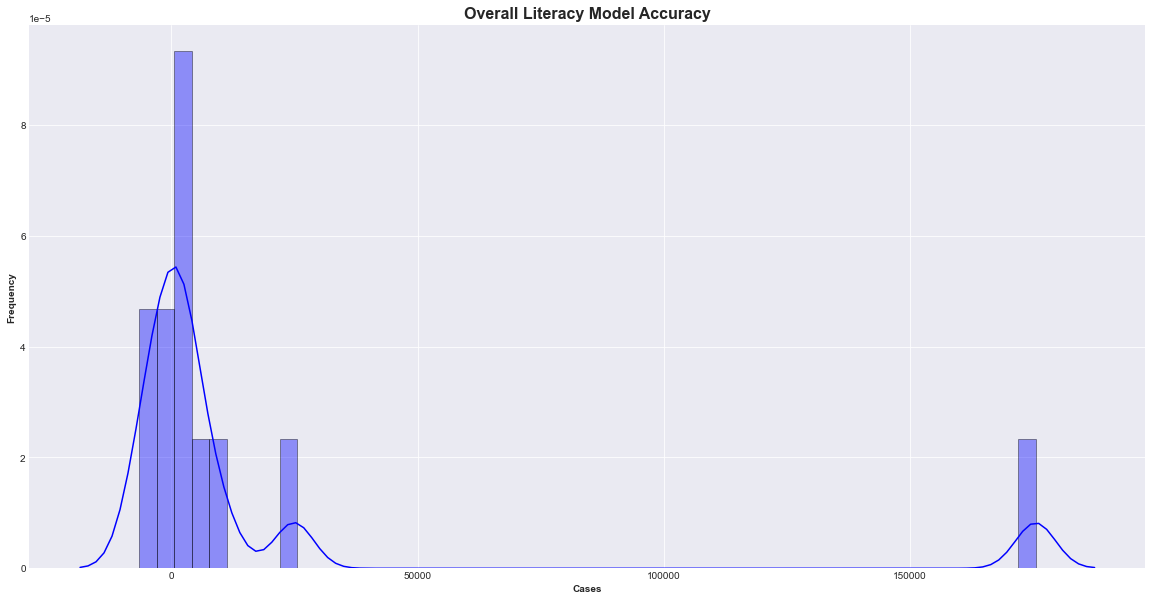

In [166]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Literacy Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [167]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2824 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 5088 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 8008 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 11568 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 15784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 20640 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 25576 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 31728 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 38536 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 45984 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  4.1min finished


In [168]:
XG_NewModel.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.06,
 'max_depth': 2,
 'min_child_weight': 2,
 'reg_lambda': 10}

In [169]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 12603.443359375
Train MSE Value: 1014721000.7167988
Train RMS Value: 31854.68569483615
Train R2 Score: 0.7903391354856171


Test MAE Value: 13234.150390625
Test MSE Value: 690354894.8487848
Test RMS Value: 26274.605512714836
Test R2 Score: -0.006597292778050656


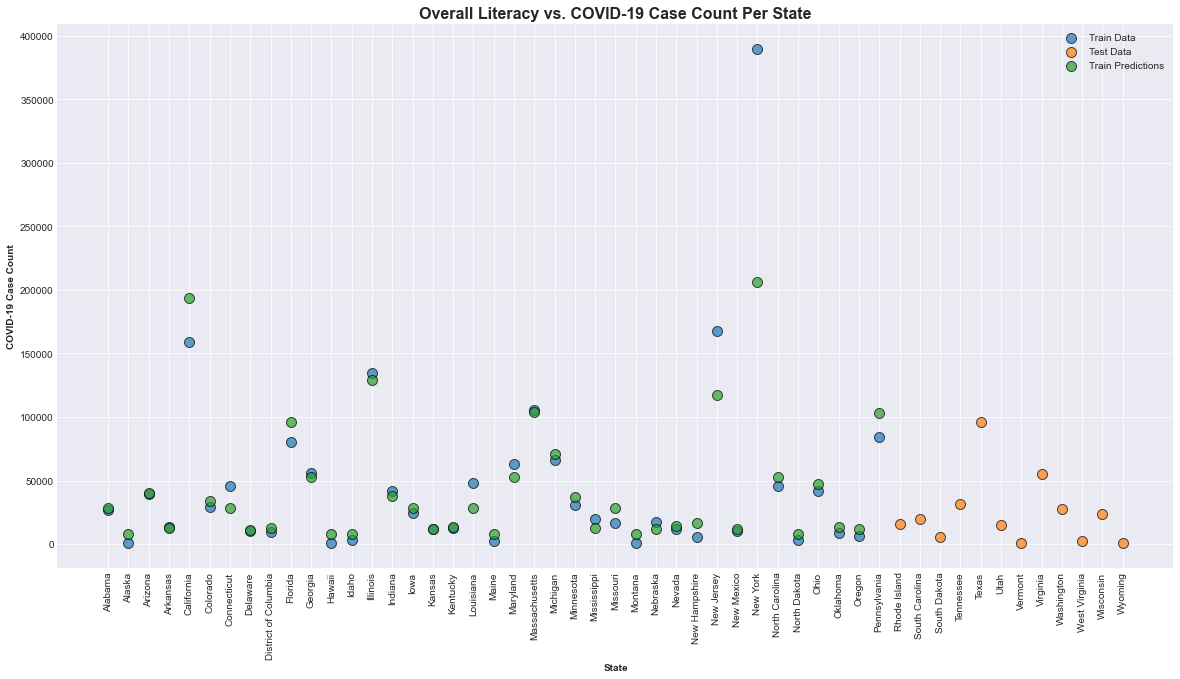

In [170]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Literacy vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

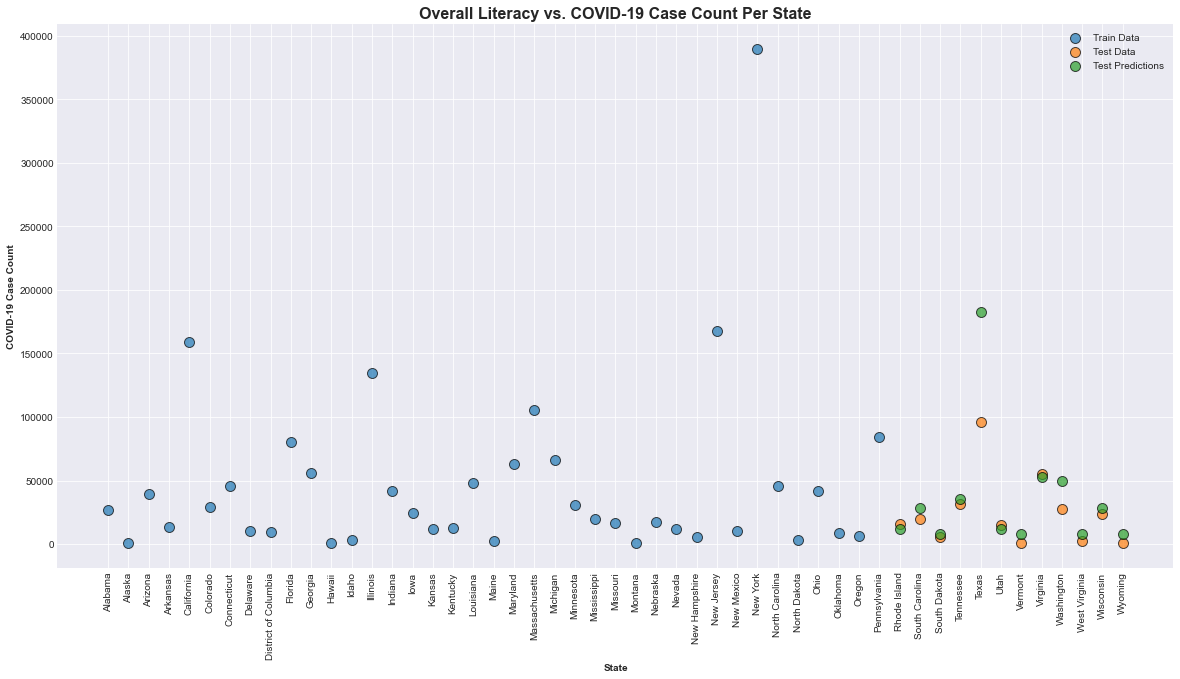

In [171]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Literacy vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [172]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8310 degrees.
Accuracy = 91.24%.


In [173]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7554 degrees.
Accuracy = 88.95%.


In [174]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of -2.57%.


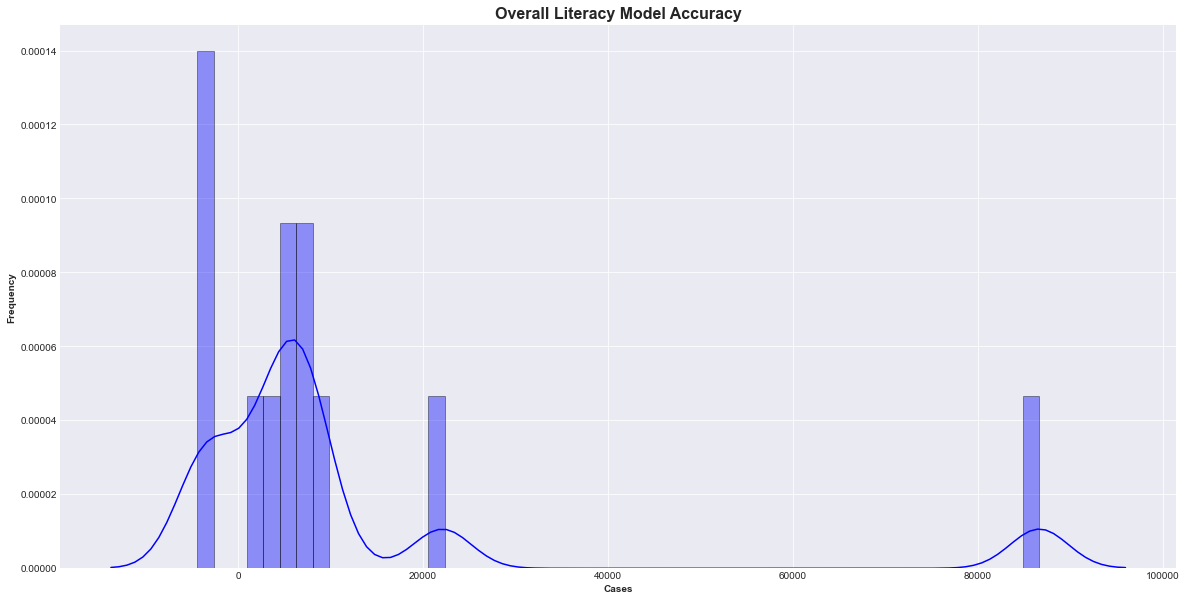

In [175]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Literacy Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();